In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm import tqdm

from lifelines.plotting import plot_lifetimes
from numpy.random import uniform, exponential

from sksurv.nonparametric import kaplan_meier_estimator
from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter
from lifelines import CoxPHFitter

from sksurv.preprocessing import OneHotEncoder

from sklearn.preprocessing import LabelEncoder

from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

import seaborn as sns

# import altair as alt

# pd.set_option('mode.chained_assignment', None)

In [2]:

# Use to restrict x-axis when displaying time-related data
DATE_RANGE = (pd.to_datetime('2016-09'), pd.to_datetime('2019-06-01'))

FIG_SIZE = (10, 6)
PALETTE = sns.color_palette()
plt.rcParams['figure.figsize'] = FIG_SIZE

def savefig(fig, name):
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )

### Load Dataset

In [5]:
df = pd.read_csv("../data/repoissuedata_v4.csv.gz", compression='gzip')
df

,message,filepath,line,column,kind,snippet,end_column,file_hash,repository,commit_hash,...,commit_mon_year,next_commit_hash,status,error_count,time_lapse,Rule,date,time,next_date,unique_worflow_id
0,"undefined variable ""go"". available variables a...",../data-raw/data-v2/workflows/e4d71b496daf9107...,19,30,expression,working-directory: ${{ go.module-path }}...,43,e4d71b496daf910760a618e45146cb4f69a8894ae1212b...,filhodanuvem---gitql,cc252e32322cbf19984cc0881d5c3961a8be6b65,...,2019-08,d936e682f76c93079bdcdc369309e8f60db1645f,closed,1.0,0 days 00:00:00,Bugs - Blocker,2019-08-08,23:40:21,2019-08-08,Claudson Oliveira/filhodanuvem---gitql/.github...
1,"undefined variable ""go"". available variables a...",../data-raw/data-v2/workflows/e4d71b496daf9107...,15,30,expression,working-directory: ${{ go.module-path }}...,43,e4d71b496daf910760a618e45146cb4f69a8894ae1212b...,filhodanuvem---gitql,cc252e32322cbf19984cc0881d5c3961a8be6b65,...,2019-08,d936e682f76c93079bdcdc369309e8f60db1645f,closed,0.0,0 days 00:00:00,Bugs - Blocker,2019-08-08,23:40:21,2019-10-28,Claudson Oliveira/filhodanuvem---gitql/.github...
2,"undefined variable ""go"". available variables a...",../data-raw/data-v2/workflows/e4d71b496daf9107...,15,30,expression,working-directory: ${{ go.module-path }}...,43,e4d71b496daf910760a618e45146cb4f69a8894ae1212b...,filhodanuvem---gitql,cc252e32322cbf19984cc0881d5c3961a8be6b65,...,2019-08,d936e682f76c93079bdcdc369309e8f60db1645f,closed,1.0,0 days 00:00:00,Bugs - Blocker,2019-08-09,23:40:21,2019-10-28,Claudson Oliveira/filhodanuvem---gitql/.github...
3,"undefined variable ""go"". available variables a...",../data-raw/data-v2/workflows/e4d71b496daf9107...,15,30,expression,working-directory: ${{ go.module-path }}...,43,e4d71b496daf910760a618e45146cb4f69a8894ae1212b...,filhodanuvem---gitql,cc252e32322cbf19984cc0881d5c3961a8be6b65,...,2019-08,d936e682f76c93079bdcdc369309e8f60db1645f,closed,1.0,0 days 00:00:00,Bugs - Blocker,2019-08-10,23:40:21,2019-10-28,Claudson Oliveira/filhodanuvem---gitql/.github...
4,"undefined variable ""go"". available variables a...",../data-raw/data-v2/workflows/e4d71b496daf9107...,15,30,expression,working-directory: ${{ go.module-path }}...,43,e4d71b496daf910760a618e45146cb4f69a8894ae1212b...,filhodanuvem---gitql,cc252e32322cbf19984cc0881d5c3961a8be6b65,...,2019-08,d936e682f76c93079bdcdc369309e8f60db1645f,closed,1.0,0 days 00:00:00,Bugs - Blocker,2019-08-11,23:40:21,2019-10-28,Claudson Oliveira/filhodanuvem---gitql/.github...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6835267,"property ""versioning"" is not defined in object...",../data-raw/data-v2/workflows/37db5a30e8968384...,30,35,expression,run: |,35,37db5a30e8968384dada935e09695e7835ee88c52225b7...,rospino74---quizlet-bypass,8aa9b8a890f8300ec727f06671e3b848713e5dec,...,2023-10,a4fcc7a18597970ea6a6501ad8084a43c65d480f,open,0.0,0 days 00:00:00,Bugs - Blocker,2023-10-11,18:03:08,2023-10-11,Marko/rospino74---quizlet-bypass/.github/workf...
6835268,"property ""versioning"" is not defined in object...",../data-raw/data-v2/workflows/d695aba7f39862cf...,30,35,expression,run: |,35,d695aba7f39862cf7573a7c007fc5a8e42230184f75601...,rospino74---quizlet-bypass,a4fcc7a18597970ea6a6501ad8084a43c65d480f,...,2023-10,NaN,closed,1.0,0 days 00:00:01,Bugs - Blocker,2023-10-11,18:03:09,2023-10-11,Marko/rospino74---quizlet-bypass/.github/workf...
6835269,"property ""versioning"" is not defined in object...",../data-raw/data-v2/workflows/d695aba7f39862cf...,13,21,expression,new-tag: v${{ steps.versioning.outputs.n...,52,d695aba7f39862cf7573a7c007fc5a8e42230184f75601...,rospino74---quizlet-bypass,a4fcc7a18597970ea6a6501ad8084a43c65d480f,...,2023-10,NaN,closed,0.0,0 days 00:00:01,Bugs - Blocker,2023-10-11,18:03:09,2023-10-12,Marko/rospino74---quizlet-bypass/.github/workf...
6835270,"label ""domestic"" is unknown. available labels ...",../data-raw/data-v2/workflows/c67c0c6045526270...,9,28,runner-label,"runs-on: [self-hosted, domestic]\n

In [6]:
df.columns

Index(['message', 'filepath', 'line', 'column', 'kind', 'snippet',
       'end_column', 'file_hash', 'repository', 'commit_hash', 'author_name',
       'author_email', 'committer_name', 'committer_email', 'committed_date',
       'authored_date', 'file_path', 'previous_file_path',
       'previous_file_hash', 'change_type', 'valid_yaml', 'probably_workflow',
       'valid_workflow', 'lines_count', 'commit_year', 'commit_mon_year',
       'next_commit_hash', 'status', 'error_count', 'time_lapse', 'Rule',
       'date', 'time', 'next_date', 'unique_worflow_id'],
      dtype='object')

In [10]:
df['commit_mon_year'].value_counts().sort_index()

2019-08      9728
2019-09     16979
2019-10     24104
2019-11     27437
2019-12     40248
2020-01     57143
2020-02     59670
2020-03     79665
2020-04     90430
2020-05    119353
2020-06    115627
2020-07    108365
2020-08    111091
2020-09    117896
2020-10    154680
2020-11    179161
2020-12    173211
2021-01    185198
2021-02    179279
2021-03    196812
2021-04    195496
2021-05    203514
2021-06    174542
2021-07    162318
2021-08    169609
2021-09    173366
2021-10    184061
2021-11    193124
2021-12    184091
2022-01    195795
2022-02    163271
2022-03    222220
2022-04    200966
2022-05    200496
2022-06    186494
2022-07    173935
2022-08    185842
2022-09    169801
2022-10    197531
2022-11    164522
2022-12    153806
2023-01    146590
2023-02    133999
2023-03    141072
2023-04    115233
2023-05    103255
2023-06     94302
2023-07     75278
2023-08     62149
2023-09     50233
2023-10     12284
Name: commit_mon_year, dtype: int64

In [4]:
# fig, ax = plt.subplots(figsize=(10, 6))

# # gettinig the number of issues per month in the year
# no_of_issue = (
#     df
# #     .drop_duplicates(['repository', 'file_path', 'commit_mon_year'], keep='last')
#     .groupby(['commit_mon_year'], sort=True)
#     .agg({'committed_date': 'count'})
#     .rename(columns={'committed_date': 'no_of_issue'})
# )

# # converting the date to numeric
# dates = mdates.date2num(no_of_issue.index)

# ax.plot(dates, no_of_issue['no_of_issue'])
# ax.set_title('Issue in Workflow files in each month of the year')
# ax.set_xlabel('Date')
# ax.set_ylabel('Issue')


# # Add the grid
# plt.grid(True)

# # Format x-axis labels as dates
# date_form = mdates.DateFormatter('%b, %Y')
# ax.xaxis.set_major_formatter(date_form)

# # ax.xaxis.set_major_locator(half_year_locator)

# plt.gcf().autofmt_xdate()

# plt.show()

## Research Question 

Q1- Which error messages combinations are more frequent than the others?  

Q2- How long it take to resolve the error message?

Q3- How much time lapse between the commits? Is there is a noticeable pattern in commit frequency ?

Q4- Do the commits made outside of the working hour has the higher error count? not interested

Q5- Are there any seasonal or temporal trends in the frequency of the introduction of the error over time? not interested


## Exploratory Data Analysis

checking the number of code quality issue in each month of the year

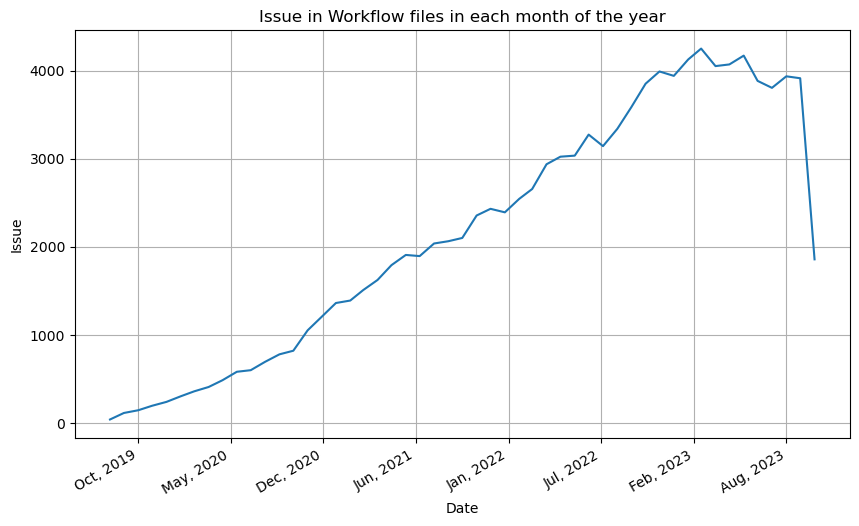

In [151]:
fig, ax = plt.subplots(figsize=(10, 6))

# gettinig the number of issues per month in the year
no_of_issue = df.groupby('commit_year_month')['message'].nunique().reset_index(name='unique_message_count')

# converting the date to numeric
dates = mdates.date2num(no_of_issue.commit_year_month.values)

ax.plot(dates, no_of_issue['unique_message_count'].values)
ax.set_title('Issue in Workflow files in each month of the year')
ax.set_xlabel('Date')
ax.set_ylabel('Issue')


# Add the grid
plt.grid(True)

# Format x-axis labels as dates
date_form = mdates.DateFormatter('%b, %Y')
ax.xaxis.set_major_formatter(date_form)

# ax.xaxis.set_major_locator(half_year_locator)

plt.gcf().autofmt_xdate()

plt.show()

In [6]:
df['kind'].value_counts()

deprecated-commands    341957
expression             273202
runner-label           125748
workflow-call           44395
matrix                  21357
events                  15626
action                  13340
syntax-check            12075
glob                     6614
job-needs                2677
id                        730
shell-name                610
env-var                   366
yaml-syntax                 6
Name: kind, dtype: int64

In [7]:
df.describe()

,line,column,end_column,authored_date,lines_count,commit_year,error_count
count,858703.000000,858703.000000,858703.000000,8.587030e+05,858703.000000,858703.000000,858703.000000
mean,233.634059,29.082004,39.788989,1.648612e+09,471.350255,2021.749662,6.949959
std,492.223324,70.817336,71.654706,3.126465e+07,850.795232,1.023047,23.023052
min,1.000000,0.000000,0.000000,1.422264e+09,5.000000,2019.000000,0.000000
25%,37.000000,14.000000,14.000000,1.624421e+09,100.000000,2021.000000,1.000000
50%,86.000000,14.000000,25.000000,1.652727e+09,205.000000,2022.000000,2.000000
75%,207.000000,28.000000,47.000000,1.674689e+09,436.000000,2023.000000,6.000000
max,11780.000000,8500.000000,8500.000000,1.697111e+09,12520.000000,2023.000000,317.000000


In [8]:
print("The number of unique messages: {}".format(df['message'].nunique()))

The number of unique messages: 24847


checking the number of code quality issues for each kind of code quality issue in workflows

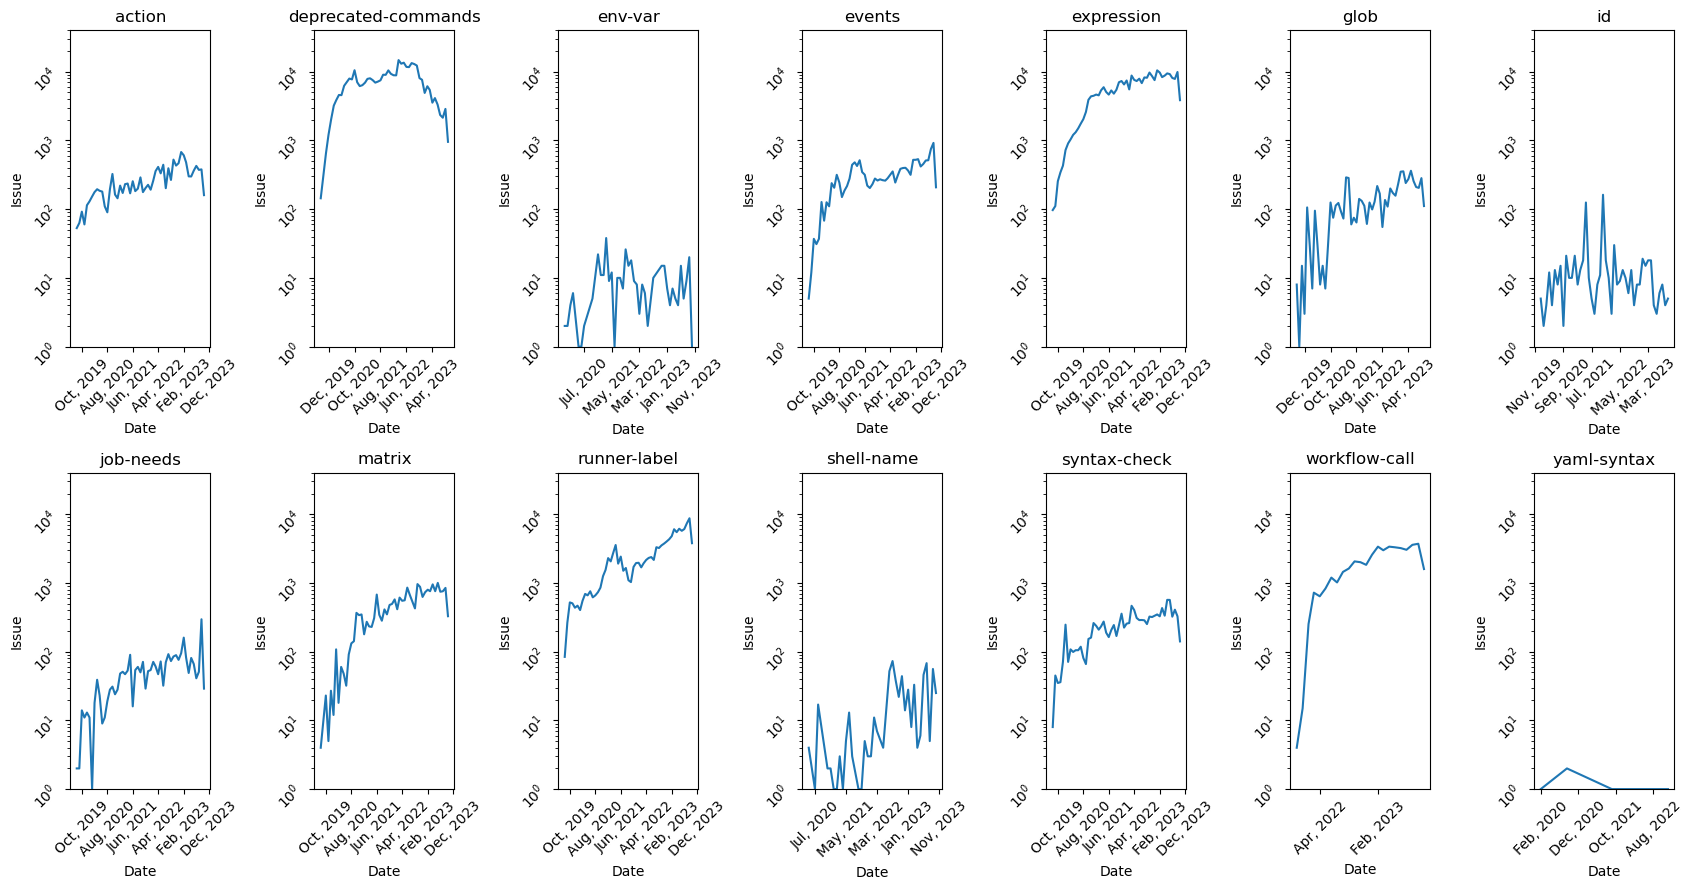

In [74]:
no_issue_kind = (
    df
    .groupby(['kind','commit_mon_year'], as_index=False)
    .agg({'committed_date': 'count'})
    .rename(columns={'committed_date': 'no_of_issue'})
)

plt.rcParams.update({'figure.figsize':(17,9), 'figure.dpi':100})

kinds = no_issue_kind['kind'].unique()

def plotnew(ax, kind):
    data = no_issue_kind[no_issue_kind['kind'] == kind]
    ax.plot(mdates.date2num(data.commit_mon_year.values), data['no_of_issue'].values)
    ax.set_xlabel('Date')
    ax.set_ylabel('Issue')
   
    ax.set_title(kind)
    
        # Format x-axis labels as dates
    date_form = mdates.DateFormatter('%b, %Y')
    ax.xaxis.set_major_formatter(date_form)

    half_year_locator = mdates.MonthLocator(interval=10)
#     monthly_locator = mdates.MonthLocator()
    
    ax.xaxis.set_major_locator(half_year_locator)
#     ax.xaxis.set_minor_locator(monthly_locator)
    ax.set_ylim(1, 40000)
    ax.set_yscale('log')
    
    ax.tick_params(labelrotation=45)

   
    
    
fig, axes = plt.subplots(nrows=2, ncols=7)

for i, ax in enumerate(axes.flat):  # Start from 1 to 4 (ax1 to ax16)
    plotnew(ax, kinds[i])
    
# plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

checking the number of code quality issues for each rule

In [158]:
df['Rule'].value_counts()

Code smells           3290809
Bugs - Blocker        2759873
Syntax Error           545384
Bugs - Non Blocker     239197
Yaml Syntax                 9
Name: Rule, dtype: int64

In [162]:
#Remove yaml syntax from the Rule
mask = df['Rule'] != 'Yaml Syntax'

# Filter DataFrame using the mask
df = df[mask]

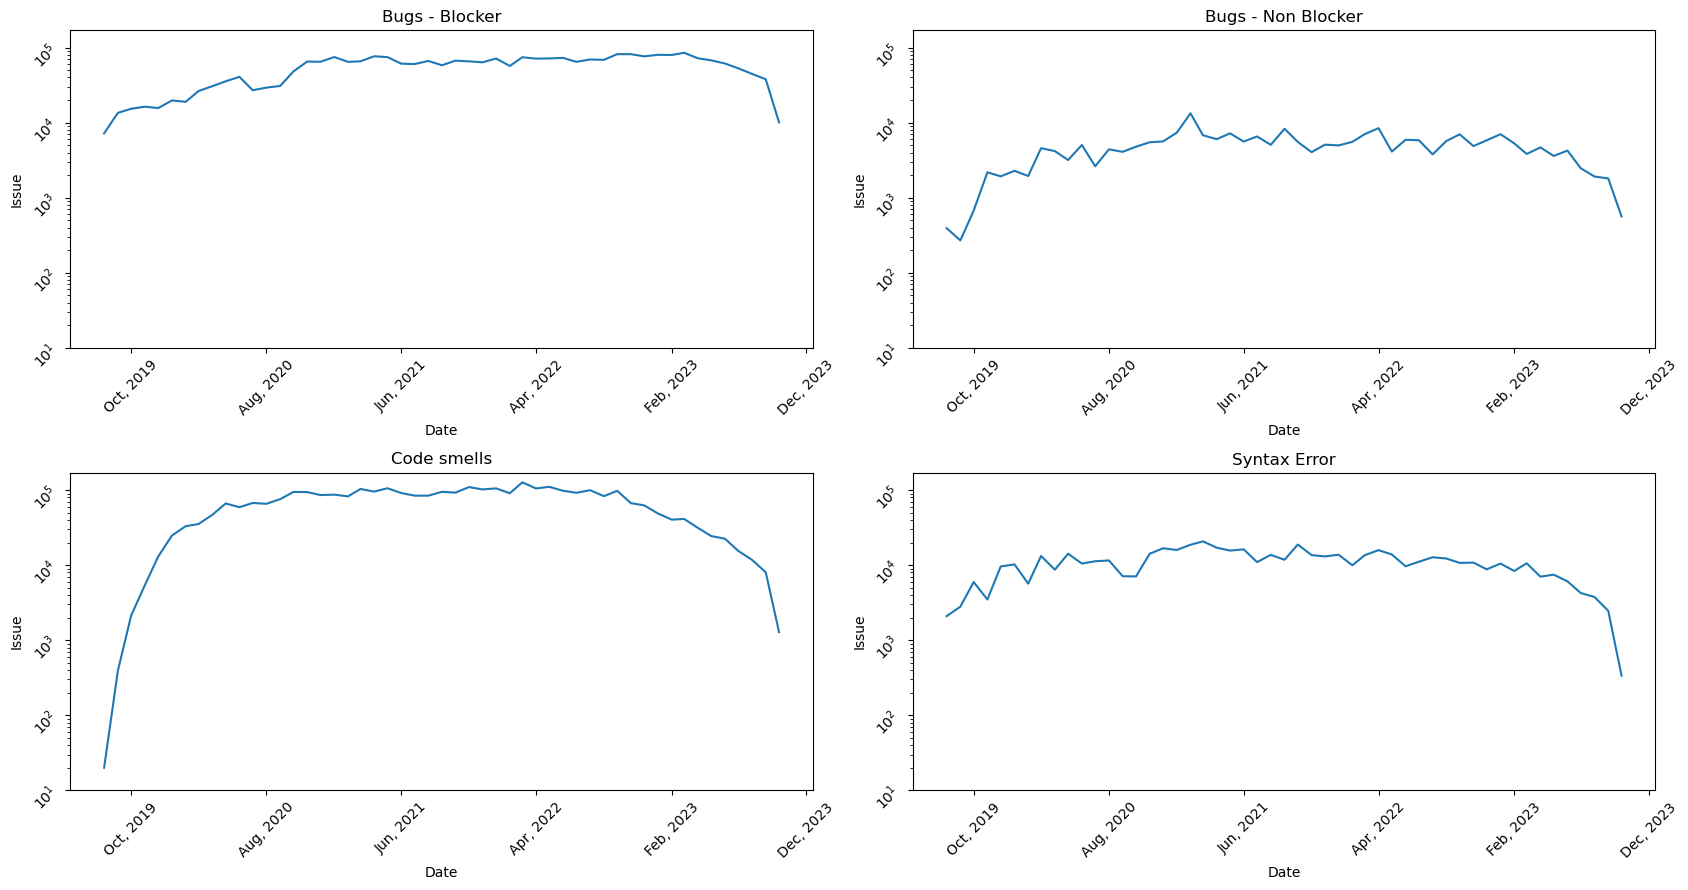

In [157]:
no_issue_rule = (
    df
    .groupby(['Rule','commit_mon_year'], as_index=False)
    .agg({'committed_date': 'count'})
    .rename(columns={'committed_date': 'no_of_issue'})
)

plt.rcParams.update({'figure.figsize':(17,9), 'figure.dpi':100})

rule = no_issue_rule['Rule'].unique()

def plot_unique_rule(ax, rule):
    data = no_issue_rule[no_issue_rule['Rule'] == rule]
    ax.plot(mdates.date2num(data.commit_mon_year.values), data['no_of_issue'].values)
    ax.set_xlabel('Date')
    ax.set_ylabel('Issue')

    
    ax.set_yscale('log')
    
    ax.set_title(rule)
    
        # Format x-axis labels as dates
    date_form = mdates.DateFormatter('%b, %Y')
    ax.xaxis.set_major_formatter(date_form)

    half_year_locator = mdates.MonthLocator(interval=10)
#     monthly_locator = mdates.MonthLocator()
    
    ax.xaxis.set_major_locator(half_year_locator)
#     ax.xaxis.set_minor_locator(monthly_locator)
    ax.set_ylim(10, 170000)
    ax.set_yscale('log')
    ax.tick_params(labelrotation=45)

   
    
    
fig, axes = plt.subplots(nrows=2, ncols=2)

for i, ax in enumerate(axes.flat):  # Start from 1 to 4 (ax1 to ax16)
    plot_unique_rule(ax, rule[i])
    
# plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [12]:
df['commit_year'].value_counts()

2022    299236
2023    235708
2021    203015
2020    114573
2019      6171
Name: commit_year, dtype: int64

The data is:[  3051  33767  89439 138738 178112]
The data is:[ 280 4177 6677 7033 7067]
The data is:[  2404  72315  98862 142121  40626]
The data is:[  436  4311  8036 11342  9903]


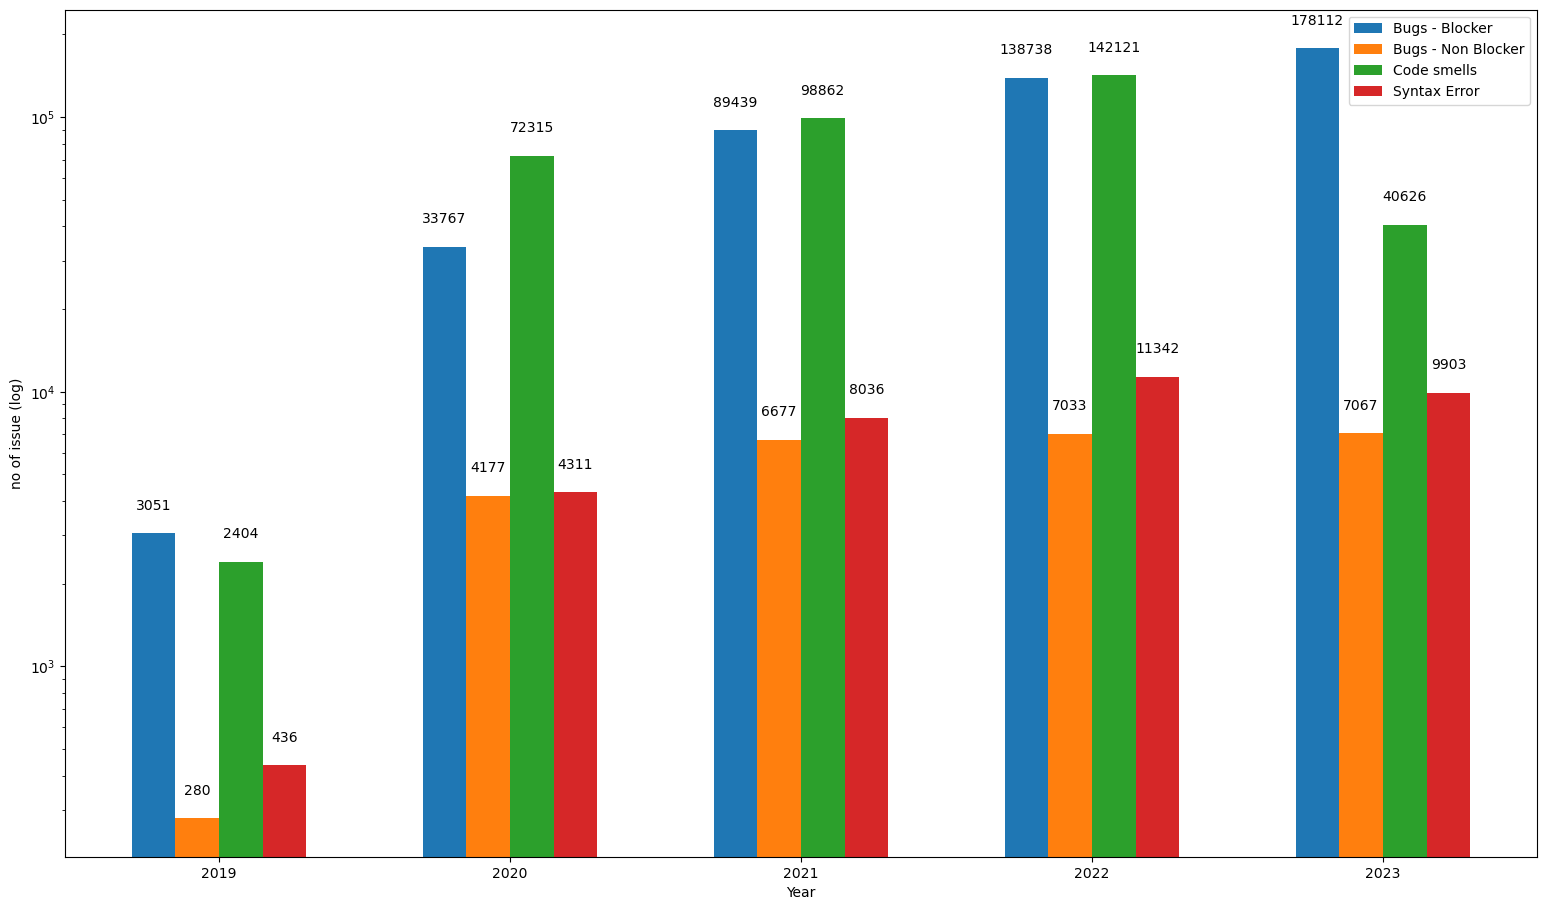

In [13]:
no_issue_per_year = (
    df
    .groupby(['Rule', 'commit_year'], as_index=False)
    .agg({'commit_hash': 'count'})
    .rename(columns={'commit_hash': 'issue'})
)

N = 5
ind = np.arange(N)  
width = 0.15
plt.rcParams.update({'figure.figsize':(19,11), 'figure.dpi':100})  

bars = []
for i, rule in enumerate(no_issue_per_year['Rule'].unique()):
    if rule == 'Yaml Syntax':
     continue
    data = no_issue_per_year[no_issue_per_year['Rule'] == rule]
    print("The data is:{}".format(data['issue'].values))
    bars.append(plt.bar(ind + width * i, data['issue'].values, width))
    plt.bar_label(bars[i], padding = 15)
    
plt.xlabel("Year")
plt.ylabel('no of issue (log)')
plt.yscale('log')
# plt.title("Players Score")

plt.xticks(ind + width * (N - 3.5), no_issue_per_year['commit_year'].unique())

legend_labels = no_issue_per_year['Rule'].unique()
plt.legend(bars, legend_labels)

plt.show()

In [14]:
no_issue_per_year

,Rule,commit_year,issue
0,Bugs - Blocker,2019,3051
1,Bugs - Blocker,2020,33767
2,Bugs - Blocker,2021,89439
3,Bugs - Blocker,2022,138738
4,Bugs - Blocker,2023,178112
5,Bugs - Non Blocker,2019,280
6,Bugs - Non Blocker,2020,4177
7,Bugs - Non Blocker,2021,6677
8,Bugs - Non Blocker,2022,7033
9,Bugs - Non Blocker,2023,7067


## Checking Feature Corelation

Converting the value of the features into numeric values

In [16]:
objects_cols = df.select_dtypes(include = ['object']).columns
df_cor = df.loc[:, ~df.columns.isin(['valid_yaml', 'probably_workflow', 'valid_workflow'])]
for col in objects_cols:
    df_cor[col] = np.uint8(LabelEncoder().fit_transform(df_cor[col]))

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_15568/2619650586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cor[col] = np.uint8(LabelEncoder().fit_transform(df_cor[col]))
/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_15568/2619650586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cor[col] = np.uint8(LabelEncoder().fit_transform(df_cor[col]))
/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_15568/2619650586.py:4: SettingWithCopyWarning: 
A value is trying

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_15568/2619650586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cor[col] = np.uint8(LabelEncoder().fit_transform(df_cor[col]))
/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_15568/2619650586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cor[col] = np.uint8(LabelEncoder().fit_transform(df_cor[col]))


In [17]:
df_cor.corr().style.background_gradient(axis=None, vmin=-1, vmax=1, ).format("{:0.2f}")

,message,filepath,line,column,kind,snippet,end_column,file_hash,repository,commit_hash,author_name,author_email,committer_name,committer_email,committed_date,authored_date,file_path,previous_file_path,previous_file_hash,change_type,lines_count,commit_year,commit_mon_year,next_commit_hash,status,error_count,time_lapse,Rule
message,1.00,0.00,0.00,0.10,0.56,0.29,0.17,0.00,0.01,-0.00,0.00,0.01,-0.00,0.03,-0.00,0.17,-0.00,-0.02,0.01,-0.01,-0.00,0.17,0.17,0.01,-0.18,0.10,-0.01,-0.54
filepath,0.00,1.00,-0.01,0.00,0.00,-0.00,0.00,1.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.01,-0.00,-0.00,-0.00,0.00,0.01,0.01,-0.00
line,0.00,-0.01,1.00,0.03,-0.01,-0.01,0.05,-0.01,0.01,0.03,-0.04,0.01,0.11,0.02,0.01,0.11,0.07,-0.14,0.00,0.06,0.84,0.11,0.11,-0.01,0.01,0.41,0.02,-0.06
column,0.10,0.00,0.03,1.00,0.02,-0.01,0.98,0.00,0.01,-0.00,0.01,0.01,0.00,-0.00,-0.01,0.03,-0.01,-0.00,-0.00,0.01,0.02,0.03,0.03,0.00,-0.02,0.03,0.00,-0.12
kind,0.56,0.00,-0.01,0.02,1.00,0.31,0.11,0.00,0.03,-0.01,-0.01,-0.01,0.03,0.04,0.01,0.32,0.01,-0.04,0.01,-0.02,-0.01,0.31,0.32,0.00,-0.19,0.09,0.00,-0.59
snippet,0.29,-0.00,-0.01,-0.01,0.31,1.00,0.05,-0.00,0.01,-0.01,0.00,0.01,-0.01,0.03,0.00,0.10,0.02,-0.04,0.00,-0.01,-0.03,0.10,0.10,0.01,-0.09,0.06,-0.00,-0.33
end_column,0.17,0.00,0.05,0.98,0.11,0.05,1.00,0.00,0.02,-0.00,0.01,0.01,0.01,-0.00,-0.01,0.08,0.00,-0.01,0.00,0.00,0.04,0.08,0.08,0.00,-0.05,0.07,0.00,-0.23
file_hash,0.00,1.00,-0.01,0.00,0.00,-0.00,0.00,1.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.01,-0.00,-0.00,-0.00,0.00,0.01,0.01,-0.00
repository,0.01,-0.00,0.01,0.01,0.03,0.01,0.02,-0.00,1.00,-0.01,0.03,-0.04,0.02,-0.03,0.00,0.02,0.04,-0.03,-0.00,0.01,0.01,0.02,0.02,0.00,0.01,0.03,0.00,-0.05
commit_hash,-0.00,0.00,0.03,-0.00,-0.01,-0.01,-0.00,0.00,-0.01,1.00,-0.02,0.01,0.01,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.04,-0.00,0.00,0.00,0.00,0.02,-0.00,0.01


checking the relationship of error count and lines count as from the above coorelation plot they are bit corelated

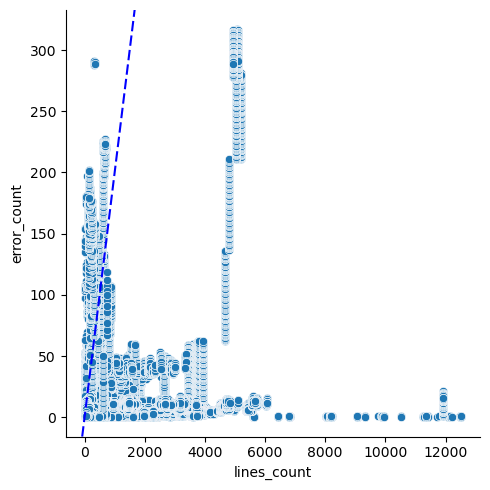

In [77]:
g = sns.relplot(data=df, x="lines_count", y="error_count")
g.ax.axline(xy1=(10, 2), slope=.2, color="b", dashes=(5, 2))

## Combination of messages w.r.t error count

In [34]:
(df['error_count'].value_counts(normalize = True) * 100)

1.0      23.250297
2.0      14.635211
0.0      13.302853
3.0       9.291804
4.0       6.828671
           ...    
316.0     0.000582
183.0     0.000582
206.0     0.000582
205.0     0.000582
317.0     0.000116
Name: error_count, Length: 318, dtype: float64

checking the combination of the messages with the error count of 3

In [37]:
error_count_2 = df[df['error_count'] == 2]

message_combinations = error_count_2[['message', 'Rule']].value_counts().reset_index(name='count')

message_combinations.head(20)

# print("The length of the message combinations with 2 error messages: ", len(message_combinations))

,message,Rule,count
0,"workflow command ""set-output"" was deprecated. ...",Code smells,48398
1,"property ""workspace"" is not defined in object ...",Bugs - Blocker,10679
2,"workflow command ""set-env"" was deprecated. use...",Code smells,5849
3,"label ""ubuntu-16.04"" is unknown. available lab...",Bugs - Blocker,2097
4,"workflow command ""add-path"" was deprecated. us...",Code smells,1799
5,"property ""node-version"" is not defined in obje...",Bugs - Blocker,1523
6,property access of object must be type of stri...,Bugs - Non Blocker,1283
7,"""github.head_ref"" is potentially untrusted. av...",Code smells,842
8,character '\' is invalid for branch and tag na...,Bugs - Non Blocker,834
9,"property ""python-version"" is not defined in ob...",Bugs - Blocker,766


checking the combination of the messages with the error count of 2

In [65]:
error_count_1 = df[df['error_count'] == 1]

message_combinations = error_count_1[['message', 'Rule']].value_counts().reset_index(name='count')

message_combinations.head(20)
# print("The length of the message combinations with 2 error messages: ", len(message_combinations))

,message,Rule,count
0,"workflow command ""set-output"" was deprecated. ...",Code smells,85210
1,"property ""workspace"" is not defined in object ...",Bugs - Blocker,20238
2,"workflow command ""set-env"" was deprecated. use...",Code smells,9712
3,"label ""ubuntu-16.04"" is unknown. available lab...",Bugs - Blocker,6157
4,"workflow command ""add-path"" was deprecated. us...",Code smells,2989
5,property access of object must be type of stri...,Bugs - Non Blocker,2923
6,"property ""node-version"" is not defined in obje...",Bugs - Blocker,2578
7,"property ""python-version"" is not defined in ob...",Bugs - Blocker,1764
8,"property ""os"" is not defined in object type {}",Bugs - Blocker,1458
9,got unexpected character '\u00a0' while lexing...,Syntax Error,1314


checking the combination of the messages with the error count of 1

In [48]:
error_count_0 = df[df['error_count'] == 0]

message_combinations = error_count_0[['message', 'Rule']].value_counts().reset_index(name='count')

message_combinations.head(20)

# print("The length of the message combinations with 1 error messages: ", len(message_combinations))

The length of the message combinations with 1 error messages:  4354


In [52]:
# Step 1: Filter the dataset
# filtered_df = df[df['error_count'] == 1]

# # Step 2: Create a frequency table for combinations of 'message'
# message_combinations = pd.crosstab(filtered_df['message'], filtered_df['message'])

# Step 3: Create a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(message_combinations_freq, cmap='coolwarm', annot=True, fmt='g')
# plt.title('Combinations of Messages for Error Count = 2')
# plt.xlabel('Message')
# plt.ylabel('Message')
# plt.xticks(rotation=45)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

checking the distribution of the error count and what type of the combinations are most likely to occur. For this we have poisson distribution. Poisson distribution shows the average number of the  events occurring in a fixed space.

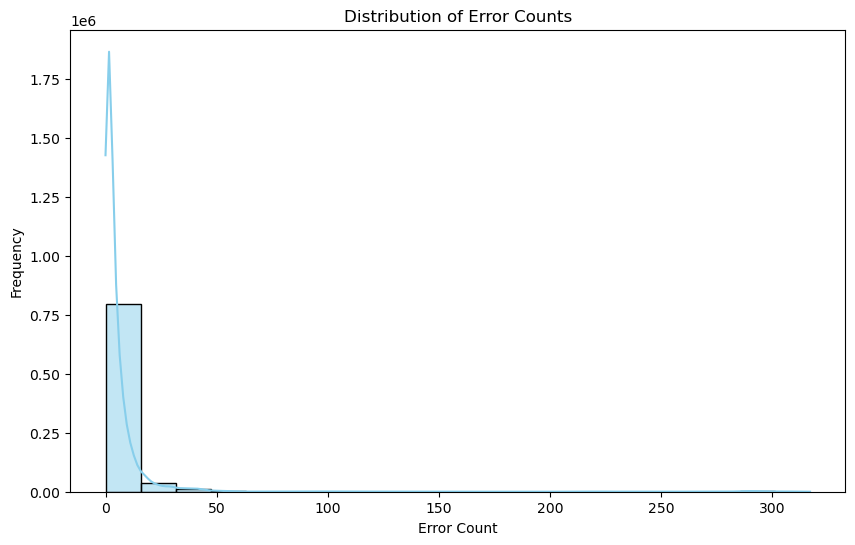

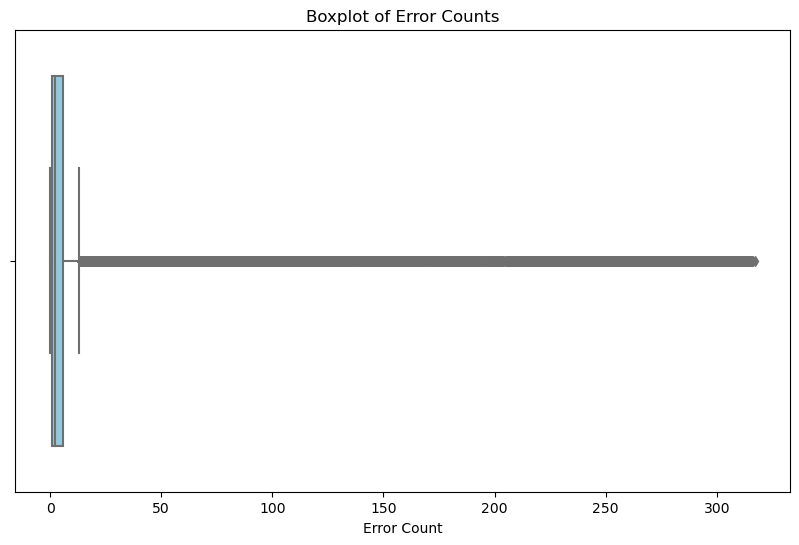

In [70]:
# Plotting the distribution of error counts
plt.figure(figsize=(10, 6))

# Histogram
sns.histplot(df['error_count'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Error Counts')
plt.xlabel('Error Count')
plt.ylabel('Frequency')

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x='error_count', color='skyblue')
plt.title('Boxplot of Error Counts')
plt.xlabel('Error Count')

plt.show()

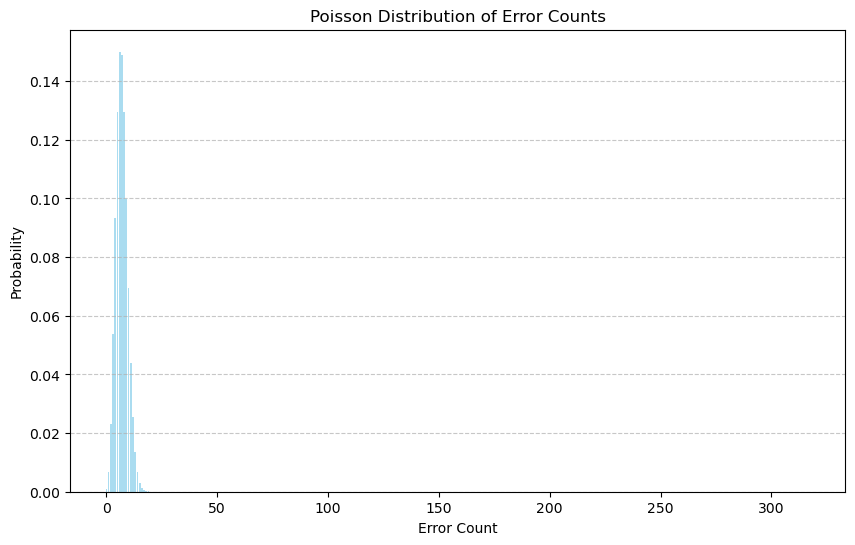

In [69]:
from scipy.stats import poisson
error_counts = df['error_count']

# Calculate the mean of error counts (lambda parameter for Poisson distribution)
mean_error_count = error_counts.mean()

# Generate the Poisson distribution
poisson_dist = poisson(mu=mean_error_count)

# Generate values for x-axis (error counts)
x_values = np.arange(0, error_counts.max() + 1)

# Calculate the probabilities for each error count
probabilities = poisson_dist.pmf(x_values)

# Plot the Poisson distribution
plt.figure(figsize=(10, 6))
plt.bar(x_values, probabilities, color='skyblue', alpha=0.7)
plt.title('Poisson Distribution of Error Counts')
plt.xlabel('Error Count')
plt.ylabel('Probability')
# plt.xticks(x_values)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Survival Models

Survival estimation can be classified into three main groups: non-parametric, semi parametric, and parametric approaches. Parametric methods depends on the assumptions that survival time correspond to the specific probability distribution. This group consisits of methods such as exponential, Weibull and lognormal distributions. In the non-parametric\ methods there are no dependencies dependent on the underlying distributions. Mostly, the non-parametric approach is used to describe survival probabilities as a function of time and give an average views of the individuals population. Most popular univariate method is the Kaplan-Meier estimator. Cox regression model comes under semi-parametric methods as it depends on parametric as well as non-parametric.

## Kaplan Meier Curve (Time Lapse)

The Kaplan Meier curve is used to graphically represent the survival rate or survival function

In [143]:
df.columns

Index(['message', 'filepath', 'line', 'column', 'kind', 'snippet',
       'end_column', 'file_hash', 'repository', 'commit_hash', 'author_name',
       'author_email', 'committer_name', 'committer_email', 'committed_date',
       'authored_date', 'file_path', 'previous_file_path',
       'previous_file_hash', 'change_type', 'valid_yaml', 'probably_workflow',
       'valid_workflow', 'lines_count', 'commit_year', 'commit_mon_year',
       'next_commit_hash', 'status', 'error_count', 'time_lapse', 'Rule'],
      dtype='object')

In [145]:
df.dtypes

message                object
filepath               object
line                    int64
column                  int64
kind                   object
snippet                object
end_column              int64
file_hash              object
repository             object
commit_hash            object
author_name            object
author_email           object
committer_name         object
committer_email        object
committed_date         object
authored_date           int64
file_path              object
previous_file_path     object
previous_file_hash     object
change_type            object
valid_yaml               bool
probably_workflow        bool
valid_workflow           bool
lines_count             int64
commit_year             int64
commit_mon_year        object
next_commit_hash       object
status                 object
error_count           float64
time_lapse             object
Rule                   object
dtype: object

In [151]:
df['time_lapse'].value_counts()

0 days 00:00:00      32303
407 days 22:59:12     1185
48 days 18:45:56       882
479 days 04:39:29      854
558 days 02:55:54      846
                     ...  
33 days 06:57:42         1
482 days 11:46:11        1
485 days 13:53:29        1
719 days 11:17:47        1
0 days 21:18:55          1
Name: time_lapse, Length: 220780, dtype: int64

In [163]:
def plot_kpl_curve(rules, dataframe):
    for rule in rules:
        if rule == 'Yaml Syntax':
            continue
        df_rule = dataframe[dataframe['Rule'] == rule]  
        df_rule['mapping_time_taken'] = df_rule['time_lapse'].apply(lambda x : False if x == "0 days 00:00:00" else True)
        df_rule['time_taken_delta'] = df_rule['time_lapse'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "0 days 00:00:00" else 0)


        kmf = KaplanMeierFitter()
        kmf.fit(durations=df_rule["time_taken_delta"], event_observed=df_rule["mapping_time_taken"])

        time = kmf.survival_function_.index.values
        survival_prob = kmf.survival_function_.values[:, 0]
        conf_int = kmf.confidence_interval_.values

        plt.step(time, survival_prob, where="post", label=rule)
        plt.fill_between(time, conf_int[:, 0], conf_int[:, 1], alpha=0.25, step="post")
        
        
    plt.ylim(0, 1)
    plt.legend(loc='upper right')
    plt.title("Kaplan Meier Curve for Rules")
    plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    
    
    
    
def plot_kpl_curve_subplot(rules, dataframe, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    for i, rule in enumerate(rules):
        if rule == 'Yaml Syntax':
            continue
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        
        df_rule = dataframe[dataframe['Rule'] == rule]
        df_rule['mapping_time_taken'] = df_rule['time_lapse'].apply(lambda x : False if x == "0 days 00:00:00" else True)
        df_rule['time_taken_delta'] = df_rule['time_lapse'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "0 days 00:00:00" else 0)

        
        
        kmf = KaplanMeierFitter()
        kmf.fit(durations=df_rule["time_taken_delta"], event_observed=df_rule["mapping_time_taken"])

        time = kmf.survival_function_.index.values
        survival_prob = kmf.survival_function_.values[:, 0]
        conf_int = kmf.confidence_interval_.values
        
        
        ax.step(time, survival_prob, where="post", label=rule)
        ax.fill_between(time, conf_int[:, 0], conf_int[:, 1], alpha=0.25, step="post")
        ax.set_ylim(0, 1)
        ax.legend(loc='upper right')
#         ax.set_title("Kaplan Meier Curve for Rule: " + rule)
        ax.set_ylabel(r"est. probability of survival $\hat{S}(t)$")
        ax.set_xlabel("time $t$")

    plt.tight_layout()
    plt.show()

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_26905/253089814.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rule['mapping_time_taken'] = df_rule['time_lapse'].apply(lambda x : False if x == "0 days 00:00:00" else True)
/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_26905/253089814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rule['time_taken_delta'] = df_rule['time_lapse'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "0 days 

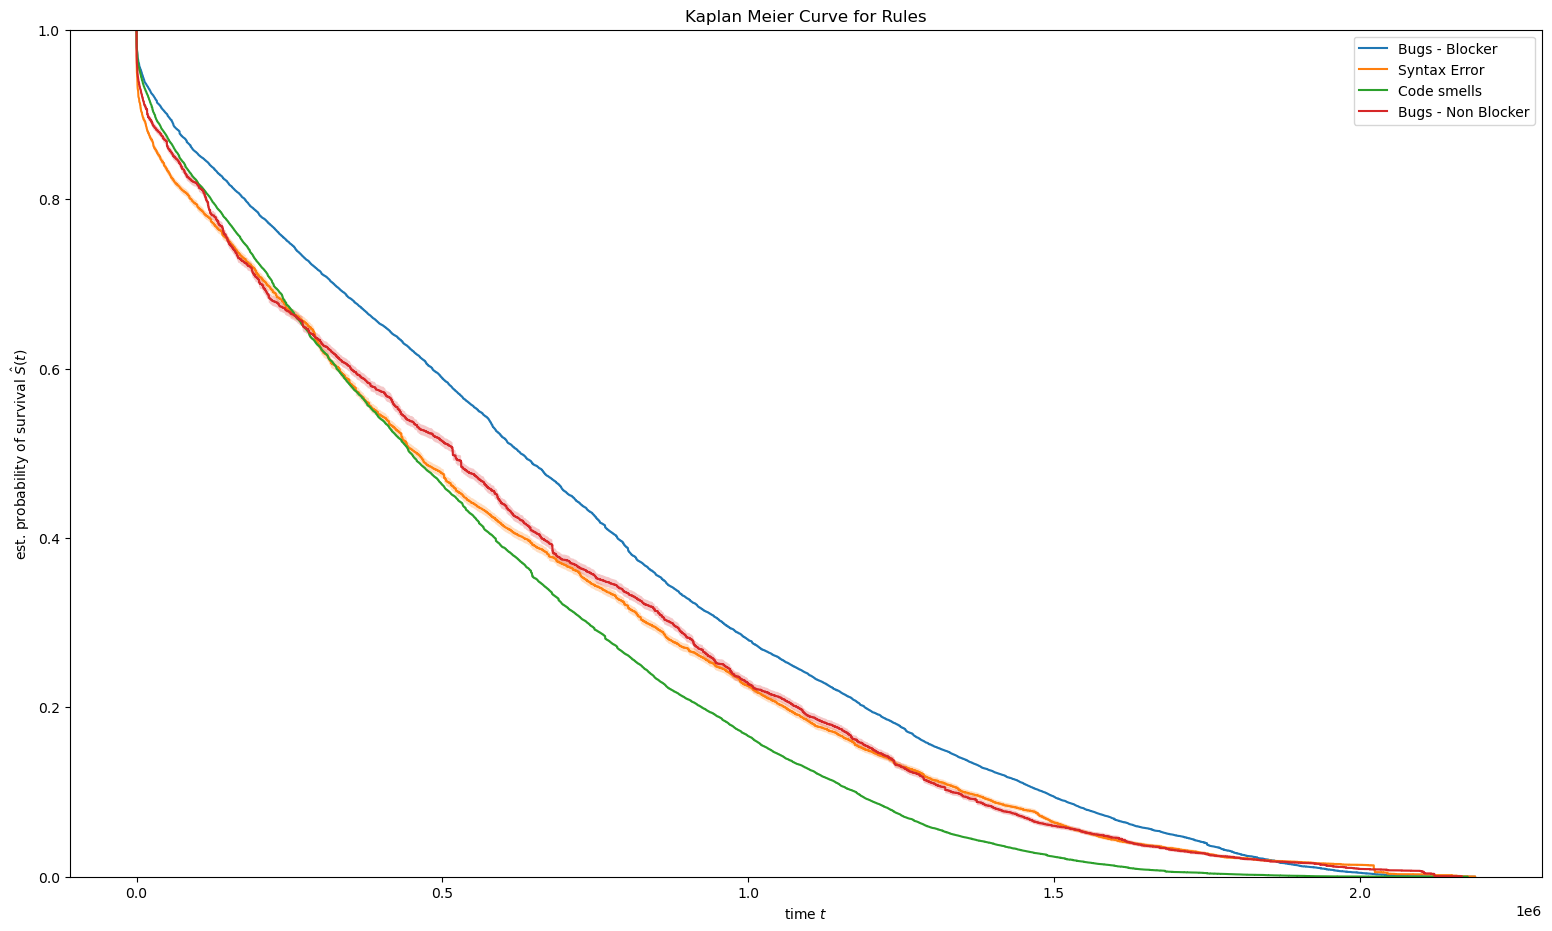

In [164]:
plot_kpl_curve(df['Rule'].unique() ,df)

The above plot shows the probabilty of the survival of the code quality issue based on the time lapse. Bug - Blocker can exist for the more time than the other code quality issue and whereas code smells has the lowest probablity of the survival.

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_26905/4207935055.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rule['mapping_time_taken'] = df_rule['time_lapse'].apply(lambda x : False if x == "0 days 00:00:00" else True)
/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_26905/4207935055.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rule['time_taken_delta'] = df_rule['time_lapse'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "0 d

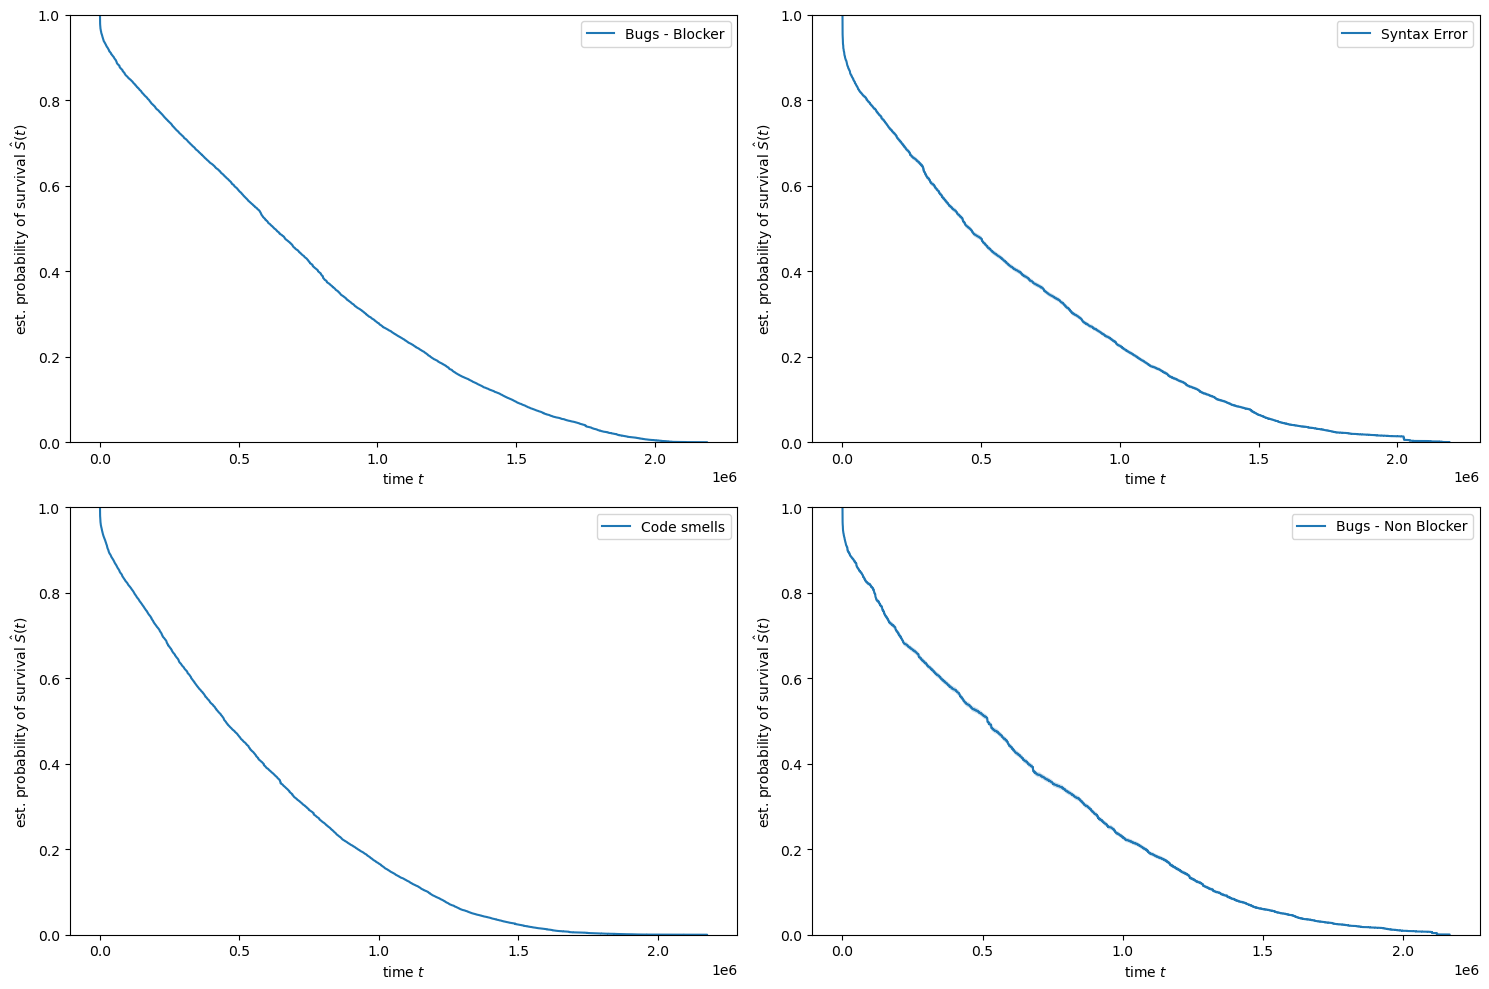

In [162]:
plot_kpl_curve_subplot(df['Rule'].unique(), df, 2, 2)

The above plot shows the probability the survival decreases with the increase of the time lapse

## Kaplan Meier Curve (Error Count)

In [165]:
df['error_count'].value_counts()

1.0      199651
2.0      125673
0.0      114232
3.0       79789
4.0       58638
          ...  
316.0         5
183.0         5
206.0         5
205.0         5
317.0         1
Name: error_count, Length: 318, dtype: int64

In [187]:
def plot_kpl_curve_error_count(rules, dataframe):
    for rule in rules:
        if rule == 'Yaml Syntax':
            continue
        df_rule = dataframe[dataframe['Rule'] == rule]  
        df_rule['mapping_error_count'] = df_rule['error_count'].apply(lambda x : False if x == 0.0 else True)
#         df_rule['time_taken_delta'] = df_rule['time_lapse'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "0 days 00:00:00" else 0)


        kmf = KaplanMeierFitter()
        kmf.fit(durations=df_rule["error_count"], event_observed=df_rule["mapping_error_count"])

        time = kmf.survival_function_.index.values
        survival_prob = kmf.survival_function_.values[:, 0]
        conf_int = kmf.confidence_interval_.values

        plt.step(time, survival_prob, where="post", label=rule)
        plt.fill_between(time, conf_int[:, 0], conf_int[:, 1], alpha=0.25, step="post")
        
        
    plt.ylim(0, 1)
#     plt.xlim(0,5)
#     plt.xticks(1,100)
    plt.legend(loc='upper right')
    plt.title("Kaplan Meier Curve for Rules")
    plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
    plt.xlabel("error count")
    
    
    
    
def plot_kpl_curve_subplot_error_count(rules, dataframe, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    for i, rule in enumerate(rules):
        if rule == 'Yaml Syntax':
            continue
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        
        df_rule = dataframe[dataframe['Rule'] == rule]
        df_rule['mapping_error_count'] = df_rule['error_count'].apply(lambda x : False if x == 0.0 else True)
#         df_rule['time_taken_delta'] = df_rule['time_lapse'].apply(lambda x : pd.to_timedelta(x, errors='coerce').total_seconds() / 60.0 if x != "0 days 00:00:00" else 0)

        
        
        kmf = KaplanMeierFitter()
        kmf.fit(durations=df_rule["error_count"], event_observed=df_rule["mapping_error_count"])

        time = kmf.survival_function_.index.values
        survival_prob = kmf.survival_function_.values[:, 0]
        conf_int = kmf.confidence_interval_.values
        
        
        ax.step(time, survival_prob, where="post", label=rule)
        ax.fill_between(time, conf_int[:, 0], conf_int[:, 1], alpha=0.25, step="post")
        ax.set_ylim(0, 1)
        ax.legend(loc='upper right')
        ax.set_title("Kaplan Meier Curve for Rule: " + rule)
        ax.set_ylabel(r"est. probability of survival $\hat{S}(t)$")
        ax.set_xlabel("error count")

    plt.tight_layout()
    plt.show()

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_26905/2388338503.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rule['mapping_time_taken'] = df_rule['error_count'].apply(lambda x : False if x == 0.0 else True)
/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_26905/2388338503.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rule['mapping_time_taken'] = df_rule['error_count'].apply(lambda x : False if x == 0.0 else True)
/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipyke

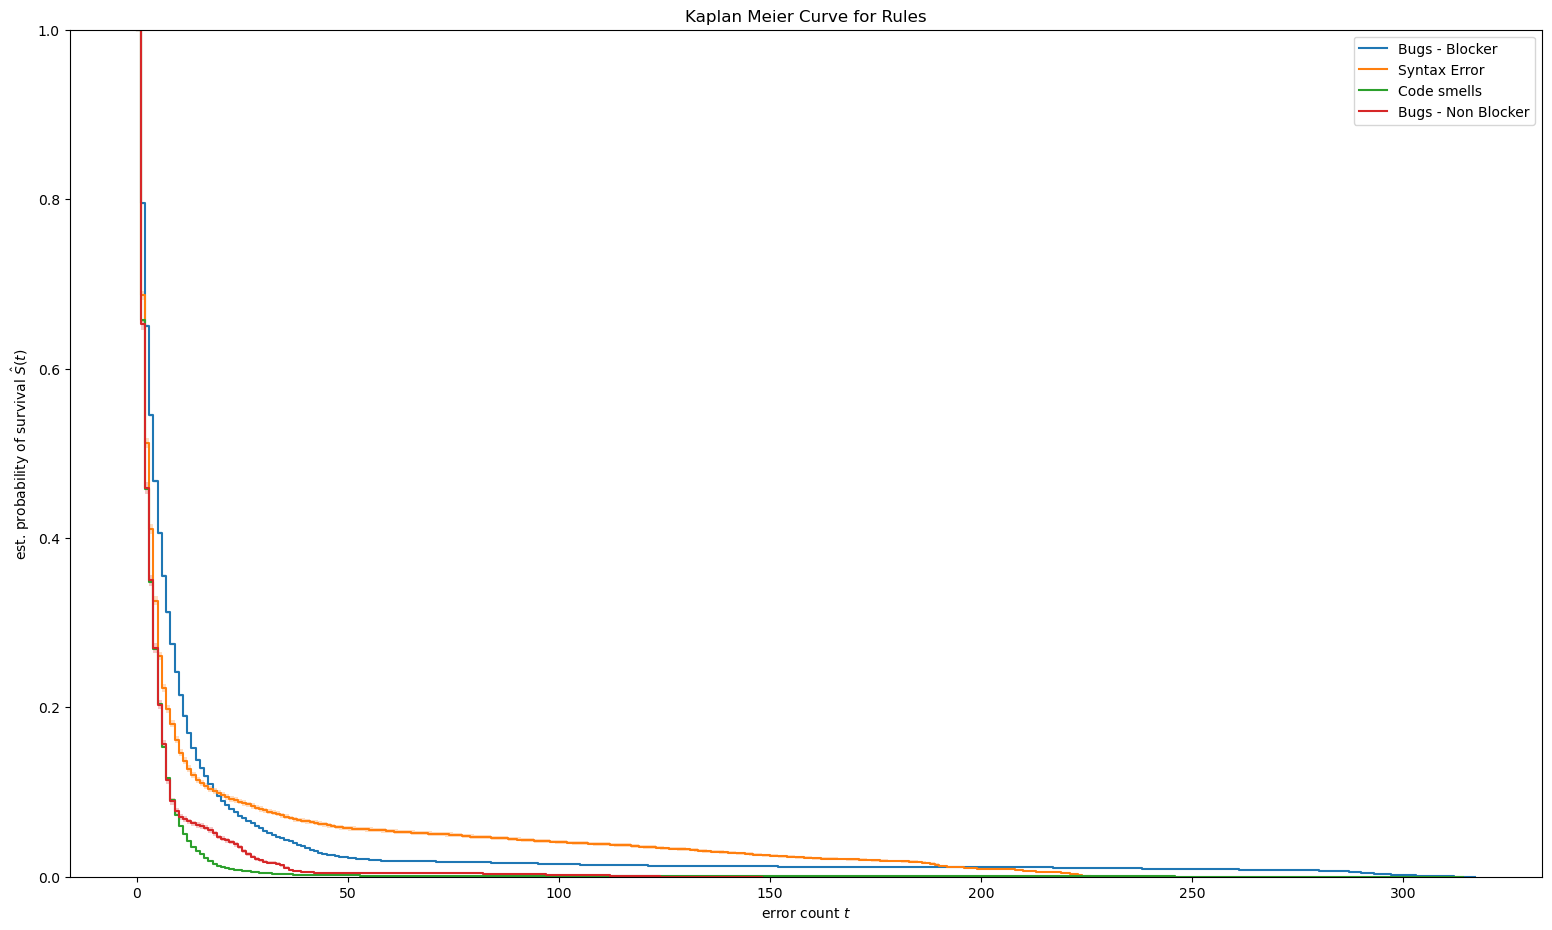

In [182]:
plot_kpl_curve_error_count(df['Rule'].unique() ,df)

## More EDA for V3 

Here a some ideas of preliminary analyses that you can conduct as soon 
as you have a dataset of "workflow ids". I phrased them as questions. By 
"workflows" or "workflow files", I mean "alive workflow ids":

** Dataset overview:
  - How many workflows are there over time?
  - How many repositories with workflows are there over time?

** Issue dataset overview:
  - How many workflows with at least one issue are there over time?
  - How many workflows have issues, per issue category, over time?
  - What's the proportion of workflows with at least one issue, over time?
  - What's the proportion of workflows having issues, per issue 
category, over time?
  - All the above 4 items, but this time by reporting on the "time 
elapsed since the workflow was added to the repository" instead of 
absolute dates;
  - All the above first 4 items, but this time by reporting on the "time 
elapsed since *a first* workflow was added to the repository";

** Last snapshot:
  - How many workflows have issues in the latest snapshot? How many 
repositories have workflows with issues? (absolute numbers + proportions)
  - What's the distribution of the number of issues for workflows with 
issues?
  - What's the distribution of the number of issues for repositories 
(including those that have no issue)?
  - Same than the last two items, but by category of issues?
  - What are the most frequent combinations of issues (per repository; 
per workflow id)?

** Evolution:
Since we detect issues based on "numbers" (i.e., we cannot keep track of 
each issue, we just got the number of issues of each type), we'll 
envision 2 scenarii: the "optimistic" one where a decrease in a number 
of issues mean the latest added issues were removed, and a "pessimistic" 
one where a decrease in a number of issues mean the first added issues 
were removed.
  - How long does it take for an issue (per category type) to be 
introduced in a workflow?
  - Same, but for repositories;
  - How long does it take for an issue (per category type) to be 
removed? (first only for issues that were actually removed, then a 
survival analysis so we can take into account the ones that were not yet 
removed)
  - Same, but for repositories;


#### How many workflows are there over time?

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_42444/2894434260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['committed_date'] = pd.to_datetime(df['committed_date'])


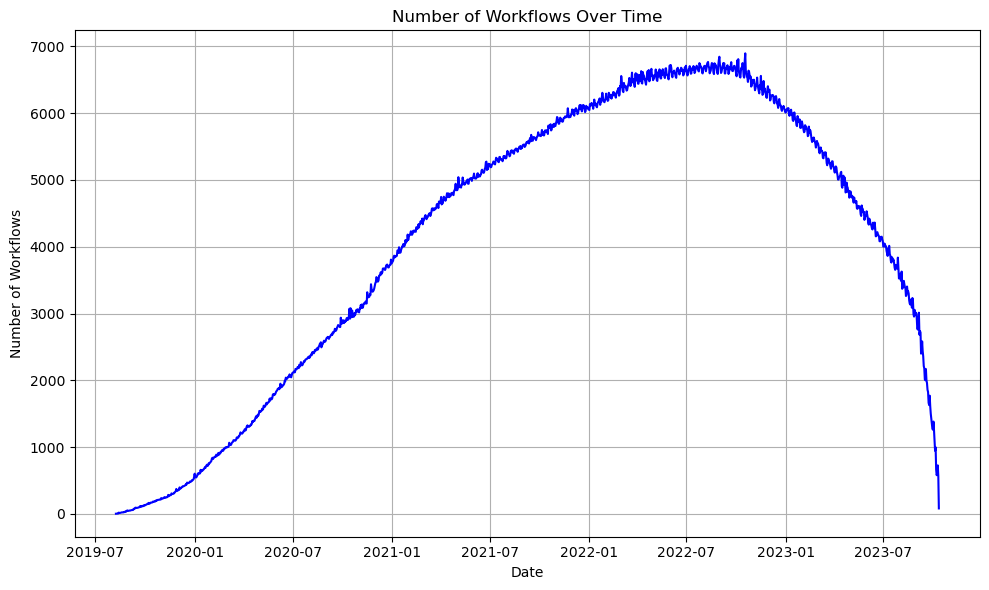

In [163]:
df['committed_date'] = pd.to_datetime(df['committed_date'])

# Group by commit date and count unique workflow IDs
workflow_counts = df.groupby(df['committed_date'].dt.date)['unique_worflow_id'].nunique()

# Plotting
plt.figure(figsize=(10, 6))
workflow_counts.plot(kind='line', color='blue')
plt.title('Number of Workflows Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Workflows')
plt.grid(True)
plt.tight_layout()
plt.show()

In [413]:
df

,message,filepath,line,column,kind,snippet,end_column,file_hash,repository,commit_hash,...,next_commit_hash,status,error_count,time_lapse,Rule,date,time,next_date,unique_worflow_id,commit_year_month
0,"undefined variable ""go"". available variables a...",../data-raw/data-v2/workflows/e4d71b496daf9107...,19,30,expression,working-directory: ${{ go.module-path }}...,43,e4d71b496daf910760a618e45146cb4f69a8894ae1212b...,filhodanuvem---gitql,cc252e32322cbf19984cc0881d5c3961a8be6b65,...,d936e682f76c93079bdcdc369309e8f60db1645f,closed,1.0,0 days 00:00:00,Bugs - Blocker,2019-08-08,23:40:21,2019-08-08,Claudson Oliveira/filhodanuvem---gitql/.github...,2019-08
1,"undefined variable ""go"". available variables a...",../data-raw/data-v2/workflows/e4d71b496daf9107...,15,30,expression,working-directory: ${{ go.module-path }}...,43,e4d71b496daf910760a618e45146cb4f69a8894ae1212b...,filhodanuvem---gitql,cc252e32322cbf19984cc0881d5c3961a8be6b65,...,d936e682f76c93079bdcdc369309e8f60db1645f,closed,0.0,0 days 00:00:00,Bugs - Blocker,2019-08-08,23:40:21,2019-10-28,Claudson Oliveira/filhodanuvem---gitql/.github...,2019-08
2,"undefined variable ""go"". available variables a...",../data-raw/data-v2/workflows/e4d71b496daf9107...,15,30,expression,working-directory: ${{ go.module-path }}...,43,e4d71b496daf910760a618e45146cb4f69a8894ae1212b...,filhodanuvem---gitql,cc252e32322cbf19984cc0881d5c3961a8be6b65,...,d936e682f76c93079bdcdc369309e8f60db1645f,closed,1.0,0 days 00:00:00,Bugs - Blocker,2019-08-09,23:40:21,2019-10-28,Claudson Oliveira/filhodanuvem---gitql/.github...,2019-08
425,"input ""version"" is not defined in action ""acti...",../data-raw/data-v2/workflows/d7d825698e4331b0...,14,9,action,version: 3.0.100-preview7-012821\n ...,16,d7d825698e4331b056fbb866ad21a49e41de4cdb67c2c2...,wieslawsoltes---dock,9ccbd91632964d7ea5cefe0f3cb0163fdd703253,...,c92808ec6a94d889e362c0a866024483db36b895,open,1.0,0 days 00:00:00,Bugs - Blocker,2019-08-09,14:43:18,2019-08-09,Wiesław Šoltés/wieslawsoltes---dock/.github/wo...,2019-08
426,"input ""version"" is not defined in action ""acti...",../data-raw/data-v2/workflows/1c28cef3677418cf...,15,9,action,version: 3.0.100-preview7-012821\n ...,16,1c28cef3677418cf496cee3b484f5092c177e8689a5d1b...,wieslawsoltes---dock,c92808ec6a94d889e362c0a866024483db36b895,...,991798fe481e6d8655659565635c12917806baed,closed,0.0,0 days 00:13:48,Bugs - Blocker,2019-08-09,14:57:06,2019-08-15,Wiesław Šoltés/wieslawsoltes---dock/.github/wo...,2019-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833657,"label ""bare-metal"" is unknown. available label...",../data-raw/data-v2/workflows/07a064e635df1d89...,526,15,runner-label,labels: bare-metal\n ^~~~~~...,24,07a064e635df1d8988463ebf234aec835e773c452b0a83...,moonbeam-foundation---moonbeam,419a4e6d281422367638e9c7a2958419c505c497,...,NaN,closed,9.0,1107 days 21:48:05,Bugs - Blocker,2023-10-12,13:22:50,2023-10-12,Alan Sapede/moonbeam-foundation---moonbeam/.gi...,2023-10
2833653,"label ""bare-metal"" is unknown. available label...",../data-raw/data-v2/workflows/07a064e635df1d89...,193,15,runner-label,labels: bare-metal\n ^~~~~~...,24,07a064e635df1d8988463ebf234aec835e773c452b0a83...,moonbeam-foundation---moonbeam,419a4e6d281422367638e9c7a2958419c505c497,...,NaN,closed,9.0,1107 days 21:48:05,Bugs - Blocker,2023-10-12,13:22:50,2023-10-12,Alan Sapede/moonbeam-foundation---moonbeam/.gi...,2023-10
2833658,"label ""bare-metal"" is unknown. available label...",../data-raw/data-v2/workflows/07a064e635df1d89...,599,15,runner-label,labels: bare-metal\n ^~~~~~...,24,07a064e635df1d8988463ebf234aec835e773c452b0a83...,moonbeam-foundation---moonbeam,419a4e6d281422367638e9c7a2958419c505c497,...,NaN,closed,10.0,1107 days 21:48:05,Bugs - Blocker,2023-10-12,13:22:50,2023-10-12,Alan Sapede/moonbeam-foundation---moonbeam/.gi...,2023-10
2833651,"label ""bare-metal"" is unknown. available label...",../data-raw/data-v2/workflows/07a064e635df1d89...,305,15,runner-label,labels: bare-met

#### How many workflows have issues, per issue category, over time?

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_42444/4160853749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['committed_date'] = pd.to_datetime(df['committed_date'])


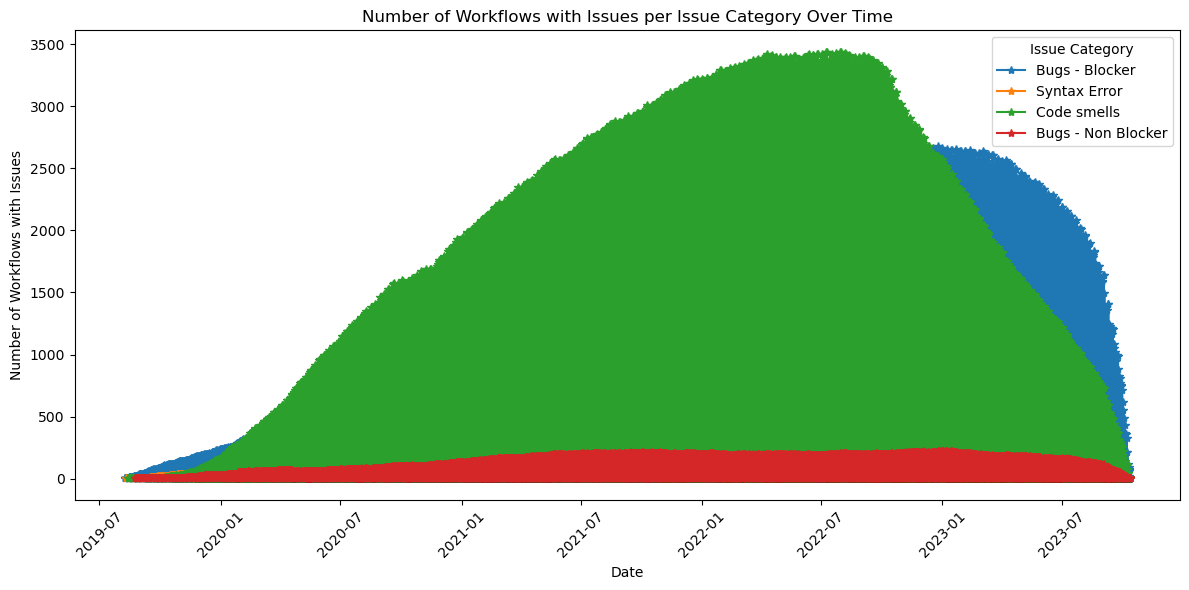

In [181]:
# Convert 'committed_date' to datetime if it's not already in datetime format
df['committed_date'] = pd.to_datetime(df['committed_date'])

# Group by 'committed_date' and 'kind' (issue category) and count the number of unique workflows
workflow_issues_per_category = df.groupby(['committed_date', 'Rule'])['unique_worflow_id'].nunique().reset_index()

# Get unique issue categories
issue_categories = workflow_issues_per_category['Rule'].unique()

# Plotting
plt.figure(figsize=(12, 6))
for category in issue_categories:
    category_data = workflow_issues_per_category[workflow_issues_per_category['Rule'] == category]
    plt.plot(category_data['committed_date'], category_data['unique_worflow_id'], label=category, linestyle='-')
    

plt.title('Number of Workflows with Issues per Issue Category Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Workflows with Issues')
plt.xticks(rotation=45)
plt.legend(title='Issue Category')
plt.tight_layout()
# Use a colormap for dimming

plt.show()

The above graph is difficult to comprehend as there are alot of values but we can see code smell appears have the highest number of workflow files from 2021-01 2022-08 then shows a generally downward trend over time. So lets try for a snapshot of the dataset for three months to get the complete overview

In [248]:
start_date = '2022-01-01 00:00:00'
end_date = '2022-02-01 00:00:00'
df = df.sort_values(by='committed_date')
df['committed_date'] = pd.to_datetime(df['committed_date'])
three_month_snapshot_df = df[(df['committed_date'] >= start_date) & (df['committed_date'] <= end_date)]

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_42444/3389529581.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_month_snapshot_df['committed_date'] = pd.to_datetime(three_month_snapshot_df['committed_date'])


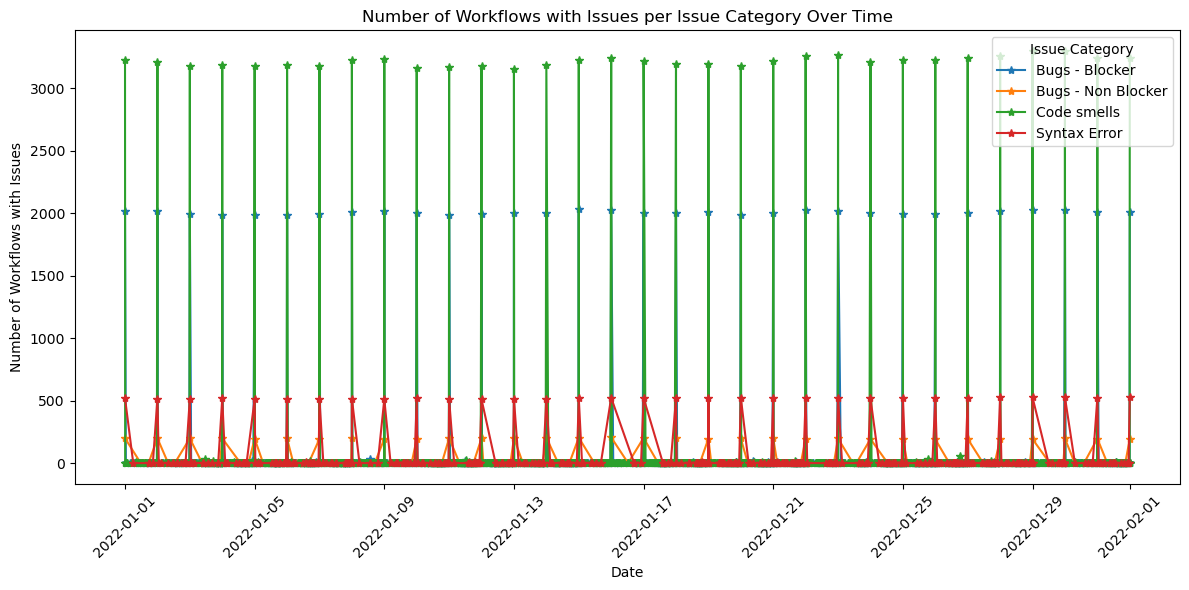

In [256]:
# Convert 'committed_date' to datetime if it's not already in datetime format
three_month_snapshot_df['committed_date'] = pd.to_datetime(three_month_snapshot_df['committed_date'])

# Group by 'committed_date' and 'kind' (issue category) and count the number of unique workflows
workflow_issues_per_category = three_month_snapshot_df.groupby(['committed_date', 'Rule'])['unique_worflow_id'].nunique().reset_index()

# Get unique issue categories
issue_categories = workflow_issues_per_category['Rule'].unique()

# Plotting
plt.figure(figsize=(12, 6))
for category in issue_categories:
    category_data = workflow_issues_per_category[workflow_issues_per_category['Rule'] == category]
    plt.plot(category_data['committed_date'], category_data['unique_worflow_id'],marker='*',  label=category)
    

plt.title('Number of Workflows with Issues per Issue Category Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Workflows with Issues')
plt.xticks(rotation=45)
plt.legend(title='Issue Category')
plt.tight_layout()
plt.show()

The trend in above plot is not interesting at all because there are alot of code smells (depreciated) error in the dataset.

#### How many workflows with at least one issue are there over time?

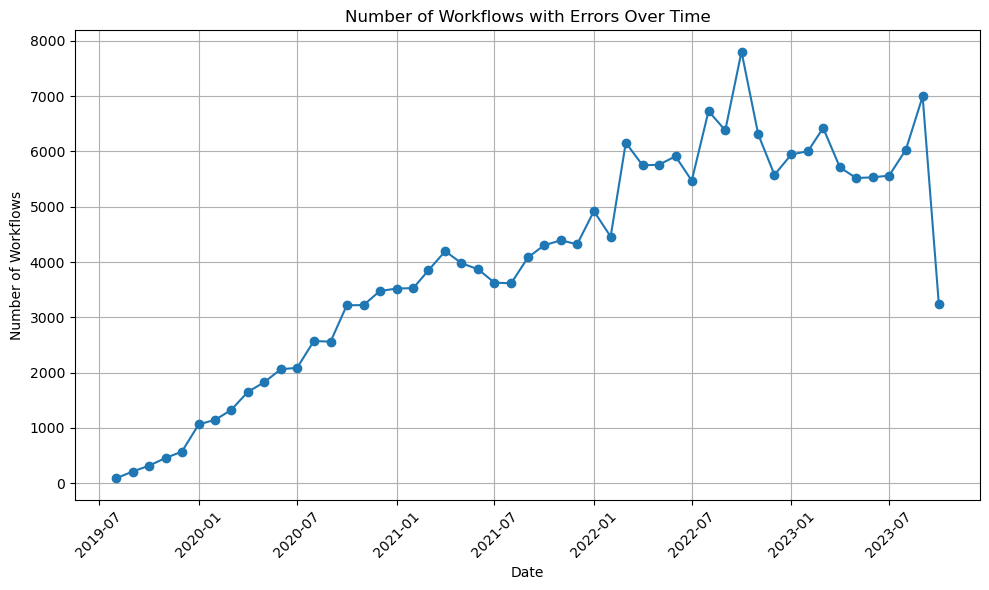

In [273]:
# Filter rows where error count is greater than zero
error_workflows = df[df['error_count'] > 0]

# Group by commit year and month-year and count unique workflows
workflow_counts = error_workflows.groupby('commit_mon_year')['unique_worflow_id'].nunique().reset_index()

# Convert commit_year and commit_mon_year to datetime
workflow_counts['date'] = pd.to_datetime(workflow_counts['commit_mon_year'], format='%Y-%m')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(workflow_counts['date'], workflow_counts['unique_worflow_id'], marker='o', linestyle='-')
plt.title('Number of Workflows with Errors Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Workflows')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

The above plot shows the trend of increasing in error over the time, highest error count is observed at fourth quater of 2022.

In [274]:
# workflow_counts = error_workflows.groupby(['commit_year', 'commit_mon_year'])['unique_worflow_id'].nunique().reset_index()
# workflow_counts

#### What's the proportion of workflows with at least one issue, over time?

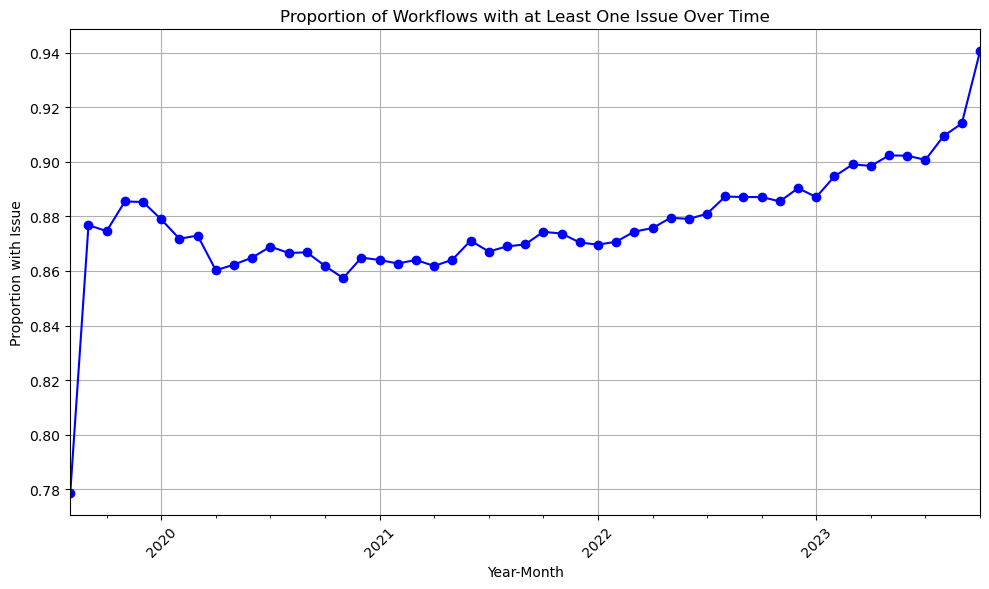

In [288]:
# Convert 'committed_date' column to datetime
df['committed_date'] = pd.to_datetime(df['committed_date'])

# Extract year and month from the 'committed_date' column
df['commit_year_month'] = df['committed_date'].dt.to_period('M')

# Group by year-month and calculate the proportion of workflows with at least one issue
proportion_with_issue = df.groupby('commit_year_month')['error_count'].apply(lambda x: (x > 0).mean())

# Plot the proportion over time
plt.figure(figsize=(10, 6))
proportion_with_issue.plot(kind='line', marker='o', color='b')
plt.title('Proportion of Workflows with at Least One Issue Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Proportion with Issue')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The above plot shows the trend of increase in the percentage of the issues. In the above plot of this plot the number of issue is low in the last month but here the percentage in the last month is highest which may be due to the number of issue is high in 2023 and we have data of only 10 months so the mean will be high in that case.

In [291]:
# proportion_with_issue = df.groupby('commit_year_month')['error_count'].apply(lambda x: (x > 0).mean())
# proportion_with_issue


#### What's the proportion of workflows having issues, per issue category, over time?

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_42444/1380182067.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grouped_data['proportion'] = grouped_data.groupby('commit_year_month')['count'].apply(lambda x: x / x.sum())


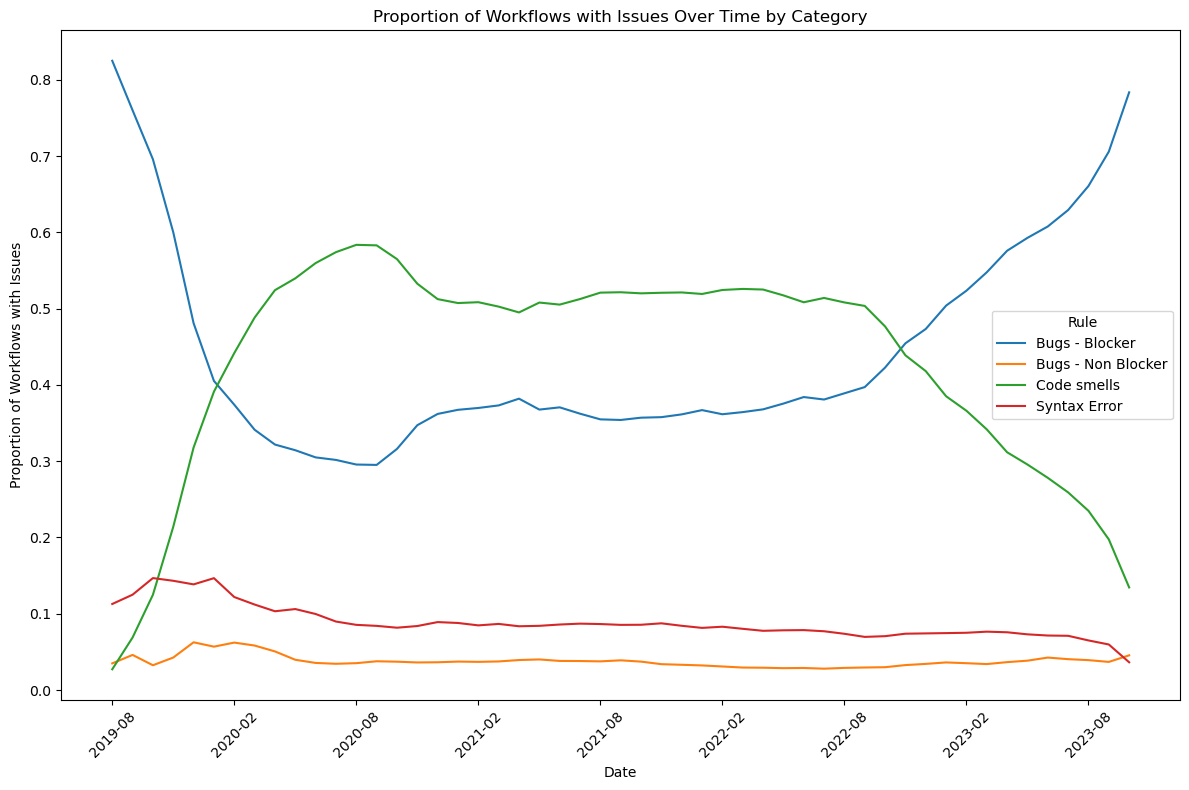

In [322]:
filtered_df = df[df['error_count'] > 0]  # Filter out rows where workflows have issues

# Group data
grouped_data = filtered_df.groupby(['commit_year_month', 'Rule']).size().reset_index(name='count')

# Calculate proportions
grouped_data['proportion'] = grouped_data.groupby('commit_year_month')['count'].apply(lambda x: x / x.sum())

grouped_data['commit_year_month'] = grouped_data['commit_year_month'].astype(str)


# Plot the data
plt.figure(figsize=(12, 8))
g = sns.lineplot(data=grouped_data, x='commit_year_month', y='proportion', hue='Rule')

plt.title('Proportion of Workflows with Issues Over Time by Category')
plt.xlabel('Date')
plt.ylabel('Proportion of Workflows with Issues')
plt.xticks(['2019-08', '2020-02', '2020-08', '2021-02', 
                   '2021-08', '2022-02', '2022-08', '2023-02', '2023-08'], rotation=45)
plt.tight_layout()
plt.show()

The above plot shows the inverse trend between the bugs blocker and code smells while the bugs non blocker has the lowest proportion

In [416]:
grouped_data = filtered_df.groupby(['commit_year_month', 'Rule']).size().reset_index(name='count')
grouped_data['proportion'] = grouped_data.groupby('commit_year_month')['count'].apply(lambda x: x / x.sum())

grouped_data[lambda d: d.commit_year_month == '2021-02']

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_42444/4065018784.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grouped_data['proportion'] = grouped_data.groupby('commit_year_month')['count'].apply(lambda x: x / x.sum())


,commit_year_month,Rule,count,proportion
72,2021-02,Bugs - Blocker,41238,0.369788
73,2021-02,Bugs - Non Blocker,4125,0.036990
74,2021-02,Code smells,56698,0.508420
75,2021-02,Syntax Error,9457,0.084802


#### How many workflows with at least one issue are there wrt to time lapse?

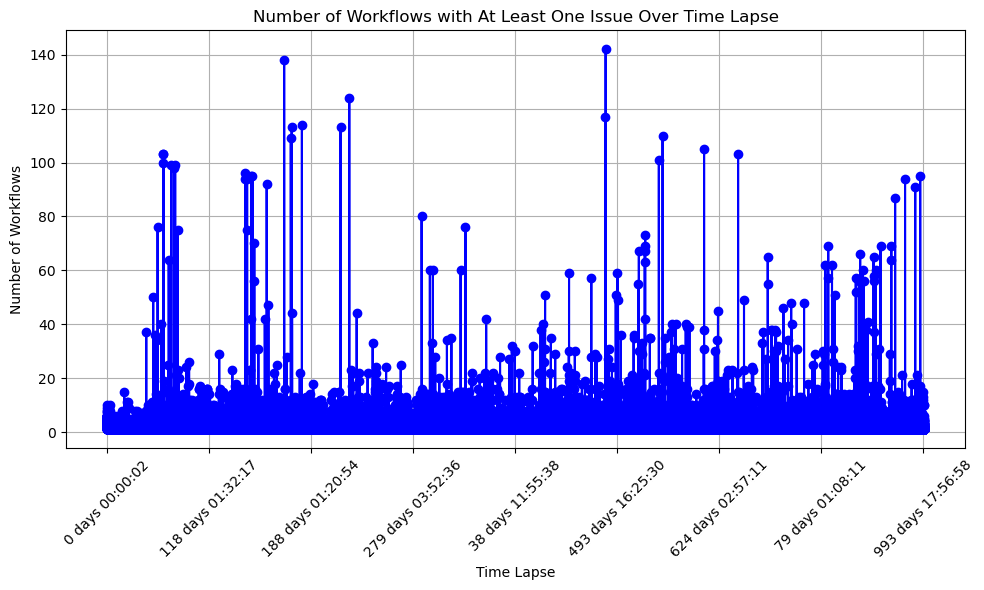

In [368]:
temp_df = df[(df['time_lapse'] != '0 days 00:00:00') & (df['time_lapse'] != '0 days 00:00:01') ]

error_df = temp_df[temp_df['error_count'] > 0]
error_df = error_df.sort_values(by='time_lapse')


# Group by time_lapse and count unique workflows

workflows_with_issues = error_df.groupby('time_lapse')['unique_worflow_id'].nunique()

plt.figure(figsize=(10, 6))
workflows_with_issues.plot(kind='line', marker='o', color='b')
# sns.lineplot(data=workflows_with_issues, x=workflows_with_issues.index, y=workflows_with_issues.values)

# Customize the plot
plt.title('Number of Workflows with At Least One Issue Over Time Lapse')
plt.xlabel('Time Lapse')
plt.ylabel('Number of Workflows')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()



In [370]:
start_date = '2020-01-01 00:00:00'
end_date = '2020-02-01 00:00:00'
df = df.sort_values(by='committed_date')
df['committed_date'] = pd.to_datetime(df['committed_date'])
one_month_snapshot_df = df[(df['committed_date'] >= start_date) & (df['committed_date'] <= end_date)]

In [411]:
def convert_to_timedelta(time_str):
    time_parts = time_str.split()
    
    # Extract days, hours, minutes, and seconds
    days = int(time_parts[0])
    time_parts = time_parts[2].split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds = int(time_parts[2])
    
    # Create timedelta object
    time_delta = timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)
    
    return time_delta

error_df['timedelta_time_lapse'] = error_df['time_lapse'].apply(convert_to_timedelta)

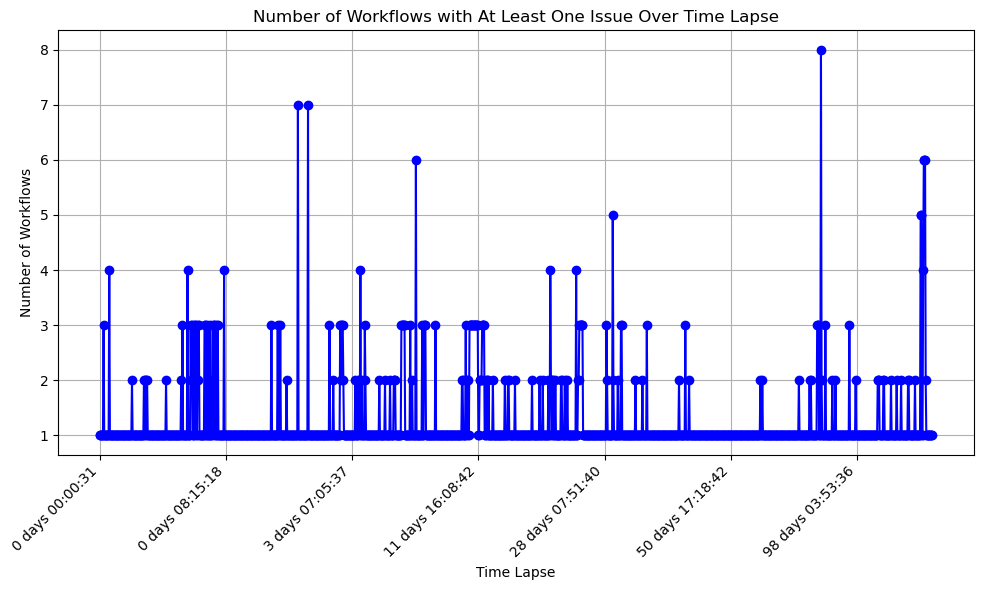

In [412]:
error_df = error_df.sort_values(by='time_lapse')


# Group by time_lapse and count unique workflows

workflows_with_issues = error_df.groupby('time_lapse')['unique_worflow_id'].nunique()

plt.figure(figsize=(10, 6))
workflows_with_issues.plot(kind='line', marker='o', color='b')
# sns.lineplot(data=workflows_with_issues, x=workflows_with_issues.index, y=workflows_with_issues.values)

# Customize the plot
plt.title('Number of Workflows with At Least One Issue Over Time Lapse')
plt.xlabel('Time Lapse')
plt.ylabel('Number of Workflows')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

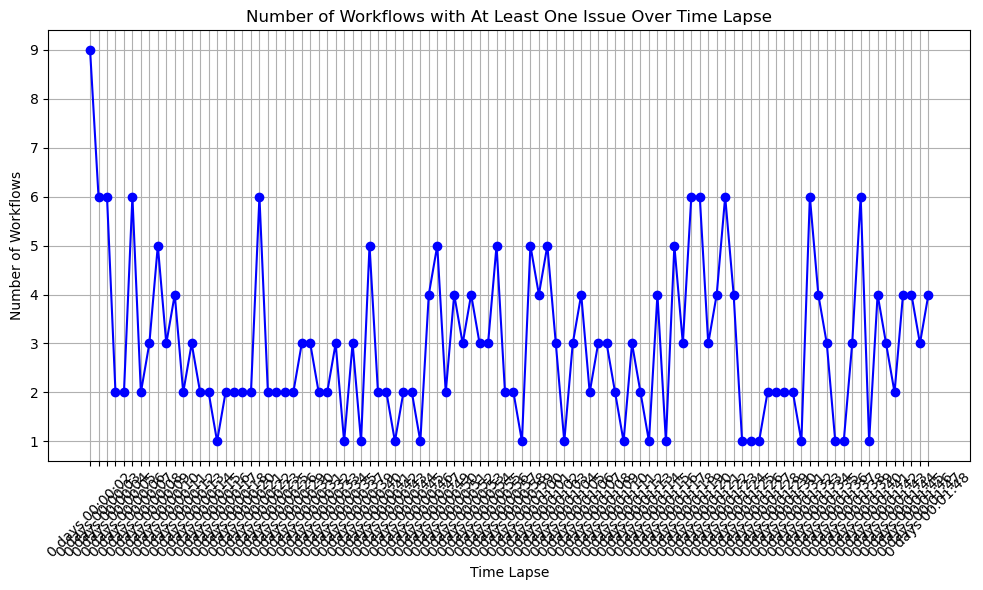

In [366]:
plt.figure(figsize=(10, 6))
plt.plot(workflows_with_issues.index[0:100], workflows_with_issues.values[0:100], marker='o', color='b')
# sns.lineplot(data=workflows_with_issues, x=workflows_with_issues.index, y=workflows_with_issues.values)

# Customize the plot
plt.title('Number of Workflows with At Least One Issue Over Time Lapse')
plt.xlabel('Time Lapse')
plt.ylabel('Number of Workflows')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

How many workflows have issues, per issue category, wrt to time lapse?

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_42444/1207410488.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['time_lapse'] = pd.to_timedelta(temp_df['time_lapse'])


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x12a510f40> (for post_execute):


KeyboardInterrupt: 

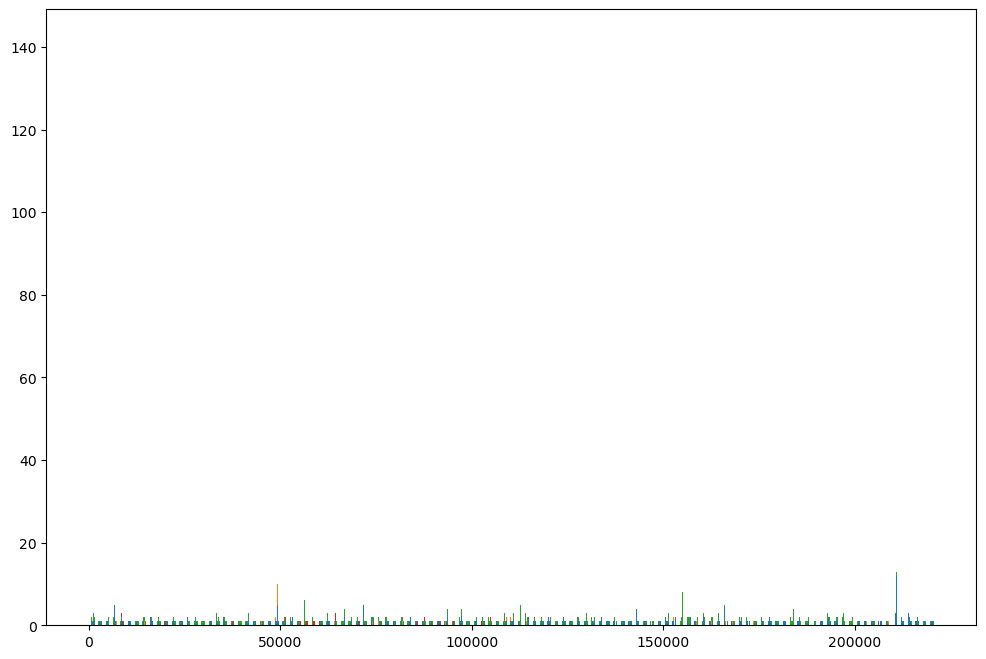

In [86]:
# 

temp_df = df[df['time_lapse'] != '0 days 00:00:00']
temp_df['time_lapse'] = pd.to_timedelta(temp_df['time_lapse'])
# Group by 'time_lapse' and 'kind' (issue category), count the number of unique workflows per category
workflow_counts = temp_df.groupby(['time_lapse', 'Rule'])['unique_worflow_id'].nunique().reset_index()

# Pivot the table to have 'time_lapse' as index, 'kind' as columns, and counts as values
workflow_counts_pivot = workflow_counts.pivot(index='time_lapse', columns='Rule', values='unique_worflow_id')

# Plot the data
workflow_counts_pivot.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Workflows with Issues per Issue Category Over Time Lapse')
plt.xlabel('Time Lapse')
plt.ylabel('Number of Workflows')
plt.legend(title='Issue Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


What's the proportion of workflows with at least one issue, wrt to time lapse?

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_42444/61082629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['time_lapse'] = pd.to_timedelta(temp_df['time_lapse'])


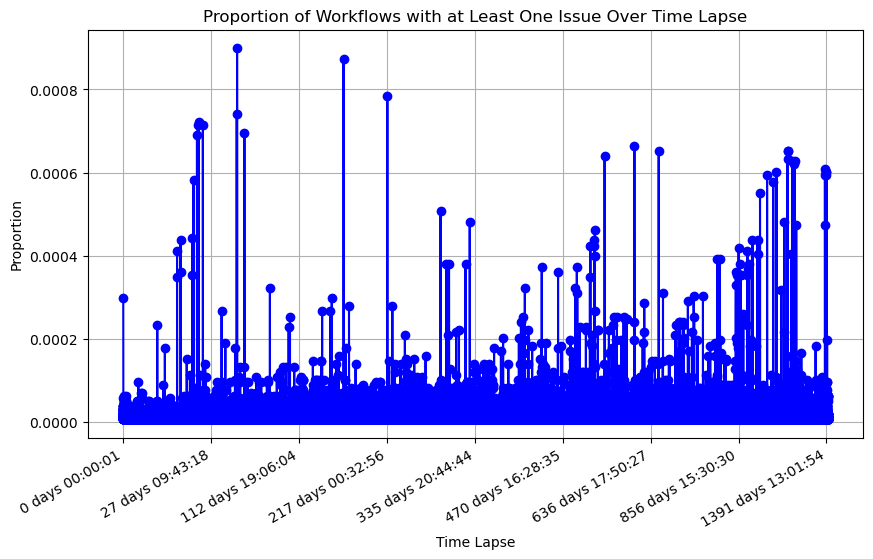

In [89]:
temp_df = df[df['time_lapse'] != '0 days 00:00:00']
temp_df['time_lapse'] = pd.to_timedelta(temp_df['time_lapse'])
df_with_issues = temp_df[temp_df['error_count'] > 0]

# Group by time lapse and count unique workflow IDs
workflow_counts = df_with_issues.groupby('time_lapse')['unique_worflow_id'].nunique()

# Calculate the proportion of workflows with issues
total_workflows = df['unique_worflow_id'].nunique()
proportion_with_issues = workflow_counts / total_workflows

# Plotting
plt.figure(figsize=(10, 6))
proportion_with_issues.plot(kind='line', marker='o', color='b')
plt.title('Proportion of Workflows with at Least One Issue Over Time Lapse')
plt.xlabel('Time Lapse')
plt.ylabel('Proportion')
plt.grid(True)
plt.show()

What's the proportion of workflows having issues, per issue category, over time lapse?

In [76]:
x = df['committed_date'][0]
y = df['committed_date'][5]

In [91]:
 z = y -x

In [92]:
hours = z.total_seconds() / 3600
hours

72.3275

In [82]:
df_temp = df.copy()

In [83]:
df_temp['time_lapse'] = pd.to_timedelta(df_temp['time_lapse'])

In [85]:
df_temp.dtypes

message                        object
filepath                       object
line                            int64
column                          int64
kind                           object
snippet                        object
end_column                      int64
file_hash                      object
repository                     object
commit_hash                    object
author_name                    object
author_email                   object
committer_name                 object
committer_email                object
committed_date         datetime64[ns]
authored_date                   int64
file_path                      object
previous_file_path             object
previous_file_hash             object
change_type                    object
valid_yaml                       bool
probably_workflow                bool
valid_workflow                   bool
lines_count                     int64
commit_year                     int64
commit_mon_year                object
next_commit_

Snapshots

Taken a snapshot of 6 months from 2022-01 to 2022-07

In [94]:
start_date = '2022-01-01 00:00:00'
end_date = '2022-07-31 00:00:00'
snapshot_df = df[(df['committed_date'] >= start_date) & (df['committed_date'] <= end_date)]


In [95]:
snapshot_df

,message,filepath,line,column,kind,snippet,end_column,file_hash,repository,commit_hash,...,next_commit_hash,status,error_count,time_lapse,Rule,date,time,next_date,unique_worflow_id,commit_year_month
1380,"workflow command ""set-env"" was deprecated. use...",../data-raw/data-v2/workflows/e7e7c6981b4ebf0c...,15,14,deprecated-commands,run: echo ::set-env name=RELEASE_VERSI...,17,e7e7c6981b4ebf0c45bf16661371f091764f8161158bea...,robfletcher---strikt,40d335c1b629b620aed3187410646b87caeebf23,...,869f8b1c7fe252ae5d9caece4bbd5e14fdae54af,closed,3.0,546 days 01:35:33,Code smells,2022-01-01,03:45:23,2023-03-27,Rob Fletcher/robfletcher---strikt/.github/work...,2022-01
1381,"workflow command ""set-env"" was deprecated. use...",../data-raw/data-v2/workflows/e7e7c6981b4ebf0c...,15,14,deprecated-commands,run: echo ::set-env name=RELEASE_VERSI...,17,e7e7c6981b4ebf0c45bf16661371f091764f8161158bea...,robfletcher---strikt,40d335c1b629b620aed3187410646b87caeebf23,...,869f8b1c7fe252ae5d9caece4bbd5e14fdae54af,closed,3.0,546 days 01:35:33,Code smells,2022-01-02,03:45:23,2023-03-27,Rob Fletcher/robfletcher---strikt/.github/work...,2022-01
1382,"workflow command ""set-env"" was deprecated. use...",../data-raw/data-v2/workflows/e7e7c6981b4ebf0c...,15,14,deprecated-commands,run: echo ::set-env name=RELEASE_VERSI...,17,e7e7c6981b4ebf0c45bf16661371f091764f8161158bea...,robfletcher---strikt,40d335c1b629b620aed3187410646b87caeebf23,...,869f8b1c7fe252ae5d9caece4bbd5e14fdae54af,closed,3.0,546 days 01:35:33,Code smells,2022-01-03,03:45:23,2023-03-27,Rob Fletcher/robfletcher---strikt/.github/work...,2022-01
1383,"workflow command ""set-env"" was deprecated. use...",../data-raw/data-v2/workflows/e7e7c6981b4ebf0c...,15,14,deprecated-commands,run: echo ::set-env name=RELEASE_VERSI...,17,e7e7c6981b4ebf0c45bf16661371f091764f8161158bea...,robfletcher---strikt,40d335c1b629b620aed3187410646b87caeebf23,...,869f8b1c7fe252ae5d9caece4bbd5e14fdae54af,closed,3.0,546 days 01:35:33,Code smells,2022-01-04,03:45:23,2023-03-27,Rob Fletcher/robfletcher---strikt/.github/work...,2022-01
1384,"workflow command ""set-env"" was deprecated. use...",../data-raw/data-v2/workflows/e7e7c6981b4ebf0c...,15,14,deprecated-commands,run: echo ::set-env name=RELEASE_VERSI...,17,e7e7c6981b4ebf0c45bf16661371f091764f8161158bea...,robfletcher---strikt,40d335c1b629b620aed3187410646b87caeebf23,...,869f8b1c7fe252ae5d9caece4bbd5e14fdae54af,closed,3.0,546 days 01:35:33,Code smells,2022-01-05,03:45:23,2023-03-27,Rob Fletcher/robfletcher---strikt/.github/work...,2022-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495196,"unexpected key ""branch"" for ""pull_request"" sec...",../data-raw/data-v2/workflows/237974715b094cad...,14,5,syntax-check,branch:\n ^~~~~~~,11,237974715b094cad7421e1098b755e41587cab253dd1c1...,unblockneteasemusic---luci-app-unblockneteasem...,ed90a2841d09fe7c7412dc98d5e59bc1f7fb2957,...,393b0784e34384aad5e7006d43d9b2a8f5a1782d,open,1.0,0 days 00:00:00,Syntax Error,2022-07-30,16:24:41,2022-11-01,Tianling Shen/unblockneteasemusic---luci-app-u...,2022-07
6495197,"unexpected key ""branch"" for ""pull_request"" sec...",../data-raw/data-v2/workflows/237974715b094cad...,14,5,syntax-check,branch:\n ^~~~~~~,11,237974715b094cad7421e1098b755e41587cab253dd1c1...,unblockneteasemusic---luci-app-unblockneteasem...,ed90a2841d09fe7c7412dc98d5e59bc1f7fb2957,...,393b0784e34384aad5e7006d43d9b2a8f5a1782d,open,1.0,0 days 00:00:00,Syntax Error,2022-07-31,16:24:41,2022-11-01,Tianling Shen/unblockneteasemusic---luci-app-u...,2022-07
6495291,"could not read reusable workflow file for ""./....",../data-raw/data-v2/workflows/d581fced1415c2b3...,11,11,workflow-call,uses: ./.github/workflows/test.yml\n ...,38,d581fced1415c2b350d0036b77a749f42fbdf96bb602dd...,luqasz---librouteros,ddc953affc80e456f387543dd575a9446d495373,...,NaN,closed,1.0,0 days 00:00:00,Bugs - Blocker,2022-07-30,19:35:00,2022-07-30,Łukasz Kostka/luqasz---librouteros/.github/wor...,2022-07
6495292,"unexpected 

How many workflows have issues in the latest snapshot? How many repositories have workflows with issues? (absolute numbers + proportions)

What's the distribution of the number of issues for workflows with issues?

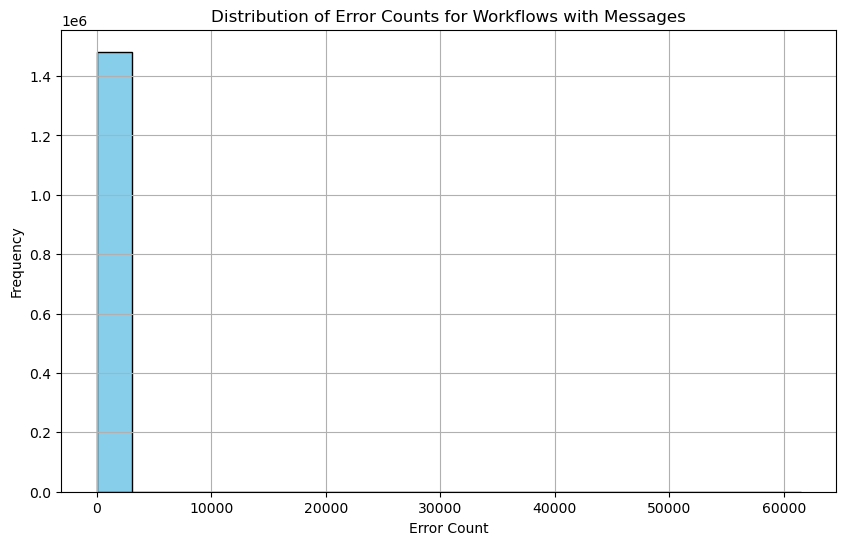

In [98]:
workflows_with_messages = snapshot_df[snapshot_df['message'].notnull()]

# Plot the distribution of error counts
plt.figure(figsize=(10, 6))
plt.hist(workflows_with_messages['error_count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Error Counts for Workflows with Messages')
plt.xlabel('Error Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [100]:
snapshot_df[snapshot_df['message'].notnull()]

Index(['message', 'filepath', 'line', 'column', 'kind', 'snippet',
       'end_column', 'file_hash', 'repository', 'commit_hash', 'author_name',
       'author_email', 'committer_name', 'committer_email', 'committed_date',
       'authored_date', 'file_path', 'previous_file_path',
       'previous_file_hash', 'change_type', 'valid_yaml', 'probably_workflow',
       'valid_workflow', 'lines_count', 'commit_year', 'commit_mon_year',
       'next_commit_hash', 'status', 'error_count', 'time_lapse', 'Rule',
       'date', 'time', 'next_date', 'unique_worflow_id', 'commit_year_month'],
      dtype='object')

What's the distribution of the number of issues for repositories (including those that have no issue)?

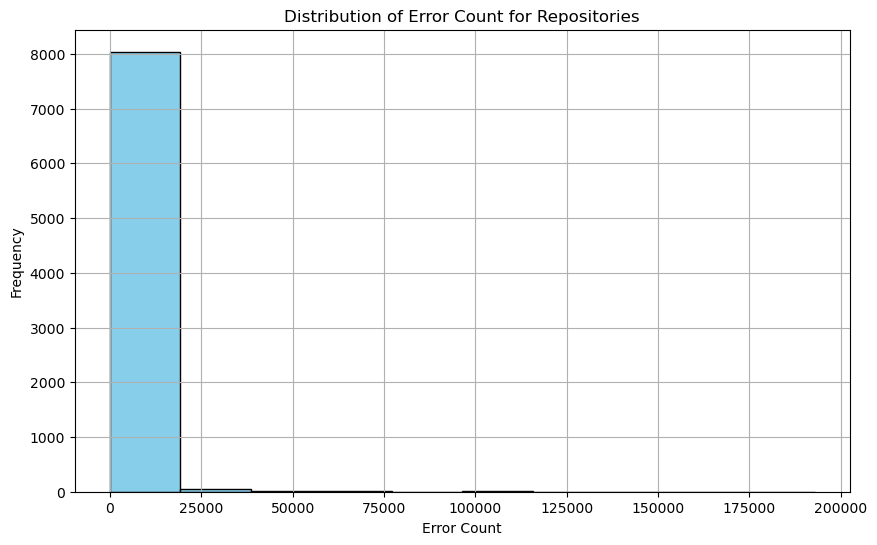

In [148]:
repo_error_count = snapshot_df.groupby('repository')['error_count'].sum()

# repo_error_count = repo_error_count.drop(repo_error_count.idxmax())

# Plotting the distribution
plt.figure(figsize=(10, 6))
repo_error_count.plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Error Count for Repositories')
plt.xlabel('Error Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [137]:
repo_error_count = snapshot_df.groupby('repository')['error_count'].sum()
repo_error_count = repo_error_count.drop(repo_error_count.idxmax()) 

In [139]:
max(repo_error_count)

1204584.0

In [146]:
filtered_series = repo_error_count.sort_values(ascending=False).iloc[5:]
max(filtered_series)

148869.0

What are the most frequent combinations of issues (per repository; per workflow id)?

In [106]:
workflow_message_counts = snapshot_df.groupby(['unique_worflow_id', 'message']).size().reset_index(name='count')

# Find the most frequent combination of messages per workflow ID
most_frequent_combinations = workflow_message_counts.groupby('unique_worflow_id').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

# Visualization
plt.figure(figsize=(12, 8))
sns.barplot(data=most_frequent_combinations, x='count', y='message', hue='unique_worflow_id', dodge=False)
plt.title('Most Frequent Message Combinations per Workflow ID')
plt.xlabel('Count')
plt.ylabel('Message')
plt.legend(title='Workflow ID', loc='upper right')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

<Figure size 1200x800 with 0 Axes>

In [107]:
workflow_message_counts = snapshot_df.groupby(['unique_worflow_id', 'message']).size().reset_index(name='count')
workflow_message_counts

,unique_worflow_id,message,count
0,(Eliseo) Nathaniel Ruiz Nowell/open-telemetry-...,"property ""python-version"" is not defined in ob...",25
1,0ft3n/auxilor---eco/.github/workflows/java-ci....,"workflow command ""set-output"" was deprecated. ...",32
2,0x192/0x192---universal-android-debloater/.git...,"property ""target"" is not defined in object typ...",32
3,0x192/0x192---universal-android-debloater/.git...,"property ""target"" is not defined in object typ...",1
4,0x192/0x192---universal-android-debloater/.git...,"property ""target"" is not defined in object typ...",143
...,...,...,...
50936,강동윤/swc-project---swc/.github/workflows/publis...,"property ""node"" is not defined in object type {}",206
50937,곽희나/nhn---tui.calendar/.github/workflows/publi...,"could not read reusable workflow file for ""./....",6
50938,임재언/nhn---tui.calendar/.github/workflows/publi...,"could not read reusable workflow file for ""./....",1
50939,임재언/nhn---tui.calendar/.github/workflows/publi...,"job ""publish-docs"" needs job ""publish-npm"" whi...",1


In [108]:
most_frequent_combinations = workflow_message_counts.groupby('unique_worflow_id').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)
most_frequent_combinations

,unique_worflow_id,message,count
0,(Eliseo) Nathaniel Ruiz Nowell/open-telemetry-...,"property ""python-version"" is not defined in ob...",25
1,0ft3n/auxilor---eco/.github/workflows/java-ci....,"workflow command ""set-output"" was deprecated. ...",32
2,0x192/0x192---universal-android-debloater/.git...,"property ""target"" is not defined in object typ...",32
3,0x192/0x192---universal-android-debloater/.git...,"property ""target"" is not defined in object typ...",1
4,0x192/0x192---universal-android-debloater/.git...,"property ""target"" is not defined in object typ...",143
...,...,...,...
48808,강동윤/swc-project---swc/.github/workflows/publis...,"property ""node"" is not defined in object type {}",206
48809,곽희나/nhn---tui.calendar/.github/workflows/publi...,"could not read reusable workflow file for ""./....",6
48810,임재언/nhn---tui.calendar/.github/workflows/publi...,"could not read reusable workflow file for ""./....",1
48811,임재언/nhn---tui.calendar/.github/workflows/publi...,"property ""cpv"" is not defined in object type {}",11


Same than the last two items, but by category of issues?